# Importación de librerias y datos

In [1]:
#Importamos librerías
#%reload_ext tgpy
#import torch
import tgpy as tg
import matplotlib.pyplot as plt
import mpl_scatter_density
import utm
import pydeck as pdk
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.metrics import mean_absolute_error

In [2]:
#Configuración para los gráficos
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
CO2_monthly = pd.read_csv("co2_mm_mlo.csv")
CO2_monthly
CO2_monthly = CO2_monthly[CO2_monthly['average'] > 0]
CO2_monthly = CO2_monthly[len(CO2_monthly.index)-200:]
CO2_monthly = CO2_monthly.reset_index()
CO2_monthly['index'] = CO2_monthly.index
CO2_monthly

index  year  month  decimal date  average  deseasonalized  ndays  sdev  \
0        0  2006      5     2006.3750   385.22          382.06     24  0.45   
1        1  2006      6     2006.4583   384.24          381.93     28  0.43   
2        2  2006      7     2006.5417   382.65          382.10     24  0.32   
3        3  2006      8     2006.6250   380.60          382.27     27  0.47   
4        4  2006      9     2006.7083   379.04          382.35     25  0.42   
..     ...   ...    ...           ...      ...             ...    ...   ...   
195    195  2022      8     2022.6250   417.19          419.16     27  0.37   
196    196  2022      9     2022.7083   415.95          419.50     28  0.41   
197    197  2022     10     2022.7917   415.78          419.13     30  0.27   
198    198  2022     11     2022.8750   417.51          419.53     25  0.52   
199    199  2022     12     2022.9583   418.95          419.65     24  0.50   

      unc  
0    0.17  
1    0.16  
2    0.12  
3    0.17  
4    0.16  
..    ...  
195  0.14  
196  0.15  
197  0.10  
198  0.20  
199  0.19  

[200 rows x 9 columns]

In [73]:
# random seed
np.random.seed(777)
t = CO2_monthly['index']
y = CO2_monthly['average']
prop = 0.5
nobs = int(prop*len(t))
perm = tg.np.random.permutation(CO2_monthly.index)
train_index = np.sort(perm[:nobs])
valid_index = np.sort(perm[nobs:])
t_obs = t[train_index]
y_obs = y[train_index]

379.04
420.99


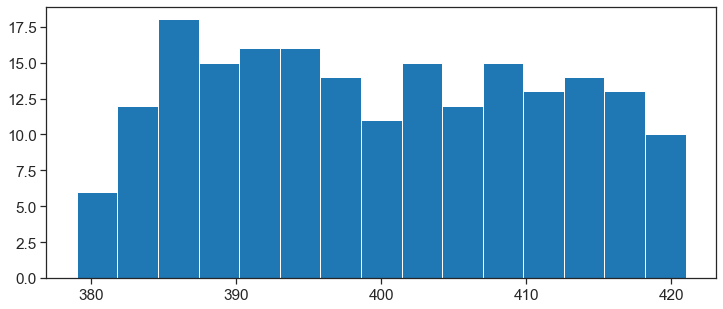

In [74]:
plt.hist(y,15)
print(min(y))
print(max(y))

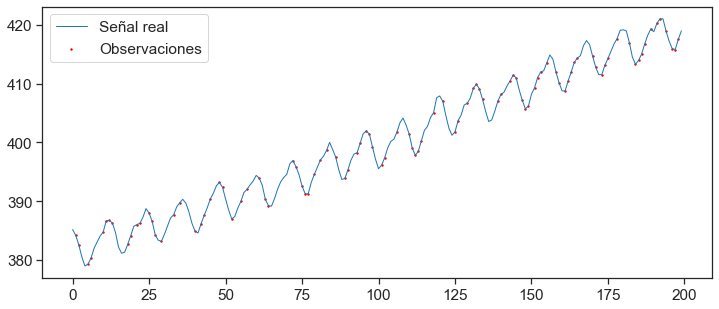

In [75]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.legend()
plt.show()

## Función de entrenamiento

In [156]:
def train(tgp, quantiles = 0.9, nsamples = 10, delta = 0.5, npoints = 21):
    tgp.sample_priors()
    tgp.plot_priors(kde=True)
    learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, rand_pert=0.0, pot=0, cycle=0.1)
    learning.execute_sgd(300)
    tgp.plot_priors(kde=True)
    return 

## Análisis de frecuencias

In [105]:
from scipy import signal

Periodos encontrados: 454.5454545454545//11.990407673860911//6.024096385542168


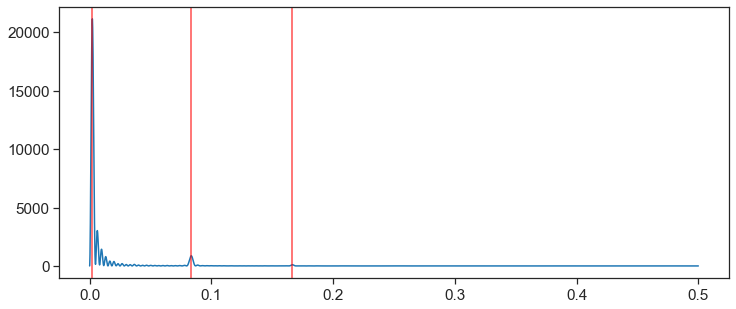

In [106]:
freqs, pxx = signal.periodogram(y, nfft=10000) #detrend
plt.plot(freqs, pxx)
plt.axvline(x=0.0022, c='r', alpha=0.7)
plt.axvline(x=0.0835, c='r', alpha=0.7)
plt.axvline(x=0.166, c='r', alpha=0.7)
T1 = 1/0.0022
T2 = 1/0.0834
T3 = 1/0.166
print('Periodos encontrados: ' + str(T1) + '//' + str(T2) + '//' + str(T3))

In [107]:
sorted(
    zip(freqs, pxx), 
    key=lambda x: x[1],
    reverse=True)

#lambda x: x[1]

[(0.0022, 21143.892420748358),
 (0.0023, 21083.542100540846),
 (0.0021000000000000003, 21004.367413469994),
 (0.0024000000000000002, 20827.21247062291),
 (0.002, 20665.10702481134),
 (0.0025, 20382.657769019483),
 (0.0019, 20130.3741234259),
 (0.0026000000000000003, 19761.22786667596),
 (0.0018000000000000002, 19408.546915059378),
 (0.0027, 18977.52877718444),
 (0.0017000000000000001, 18512.015363365786),
 (0.0028, 18049.01597148203),
 (0.0016, 17456.9825451747),
 (0.0029000000000000002, 16995.53169735431),
 (0.0015, 16263.174252740597),
 (0.003, 15838.798685181137),
 (0.0014, 14953.462483965382),
 (0.0031000000000000003, 14601.883466312147),
 (0.0013000000000000002, 13553.410672591579),
 (0.0032, 13308.643021751008),
 (0.0012000000000000001, 12090.750544936565),
 (0.0033, 11983.168609143051),
 (0.0034000000000000002, 10649.240387844713),
 (0.0011, 10594.802293099952),
 (0.0035, 9329.80588712191),
 (0.001, 9095.851277670828),
 (0.0036000000000000003, 8046.494462409644),
 (0.00090000000

# Pruebas Modelos Intrapolación

## Kernel RQ

In [17]:
def modelRQ(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_rq = tg.TgPrior('var_rq', ['Average'], dim=dim, low=0, high=2, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Average'], dim=dim, low=0.0, high=1, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 

    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp


In [18]:
tgp = modelRQ(CO2_monthly, train_index)

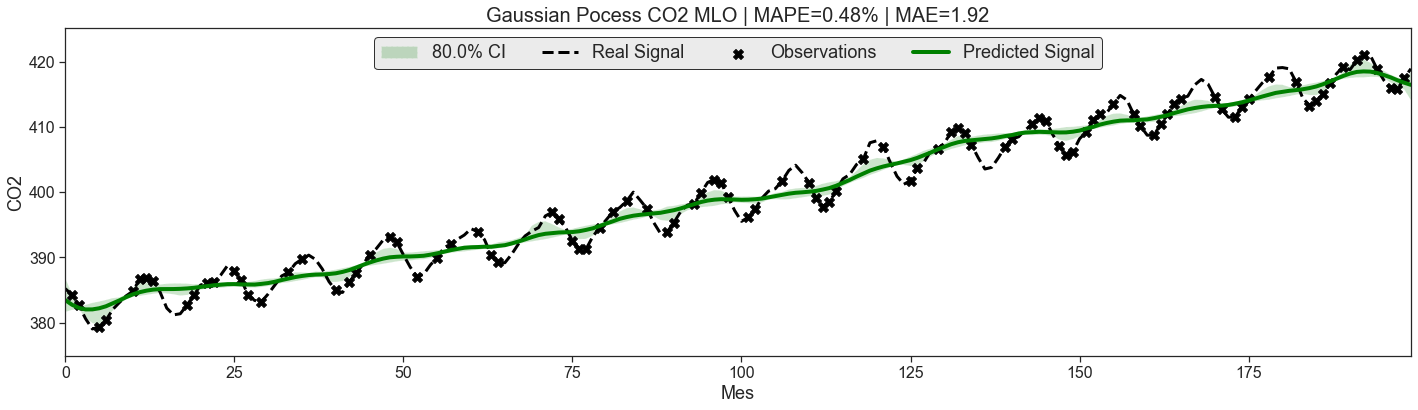

In [20]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=1, valid_index=valid_index, plot_samples = False, 
                 noise = True)

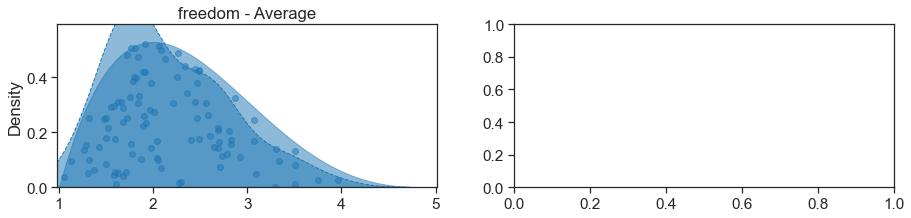

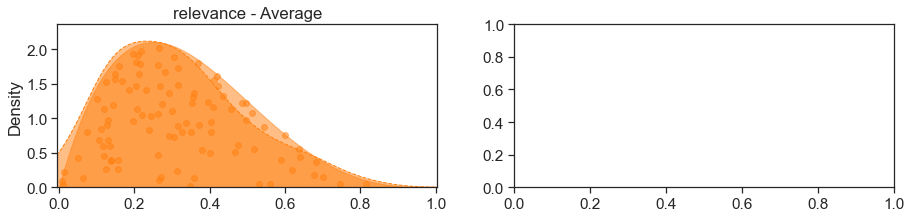

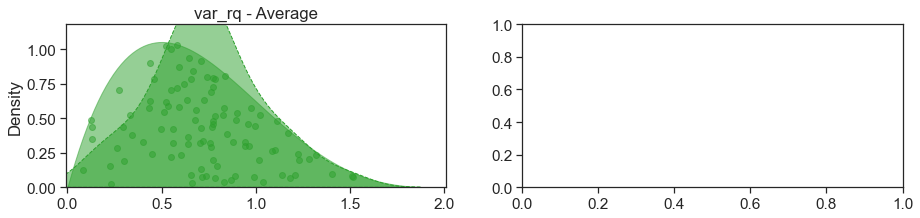

  0%|                                                                                                         …

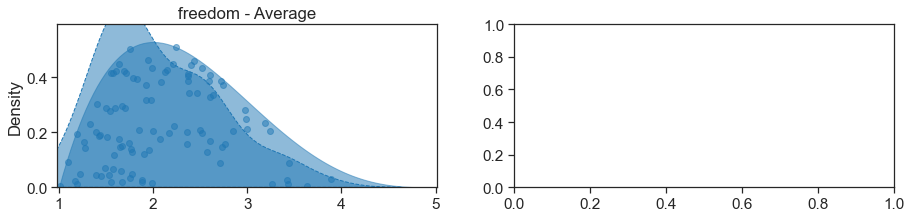

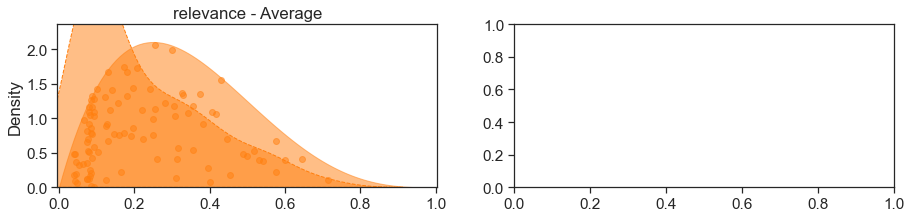

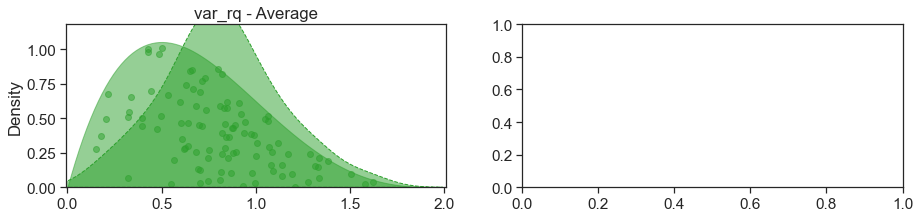

In [21]:
train(tgp, train_index)

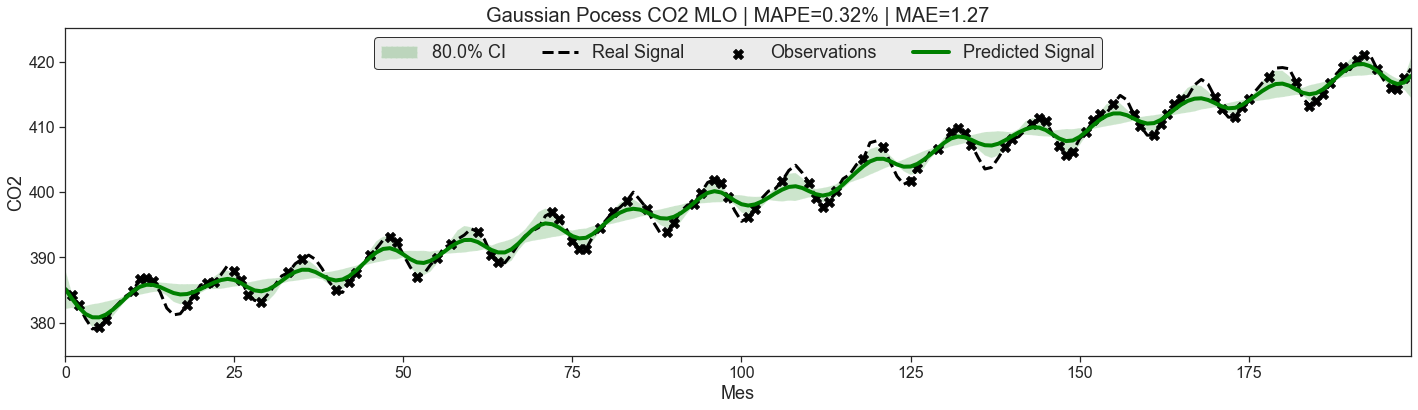

In [22]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True, samples_kwargs = {'alpha':0.1})

## Kernel Sin

In [32]:
def modelSin(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPrior('var_rq', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4) #0-2
    relevance = tg.TgPrior('relevance', ['Average'], dim=dim, low=0.0, high=2, alpha=2, beta=4) #low = 0.0, high = 2
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0.04, high=0.08, alpha=2, beta=4) #low = 1, high = 5 
    
    kernel = tg.SIN(var_sin, relevance, period)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [33]:
tgp = modelSin(CO2_monthly, train_index)

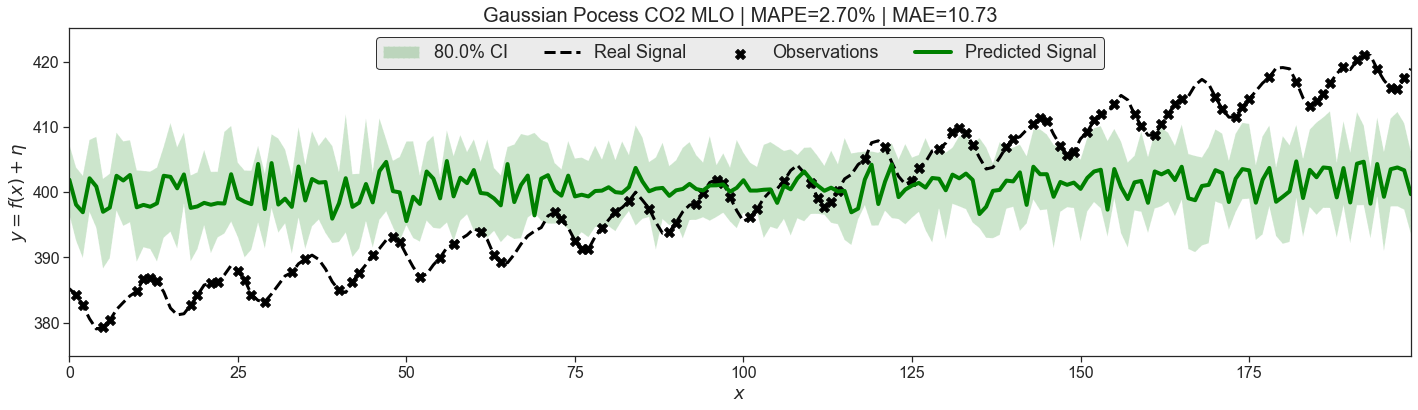

In [34]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', nsamples=1, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

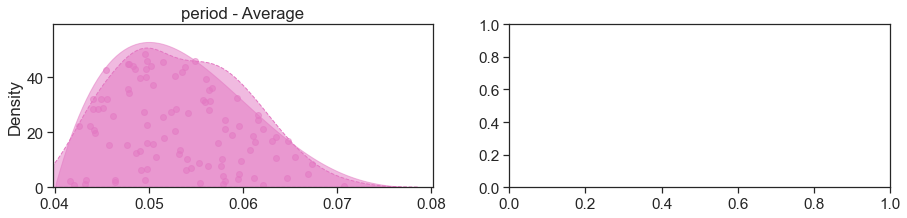

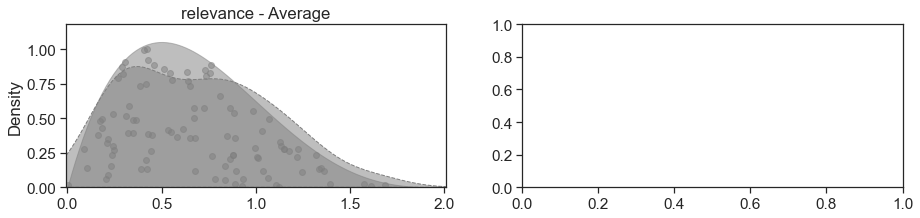

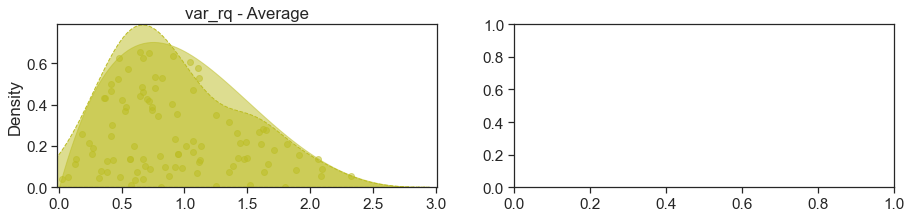

  0%|                                                                                                         …

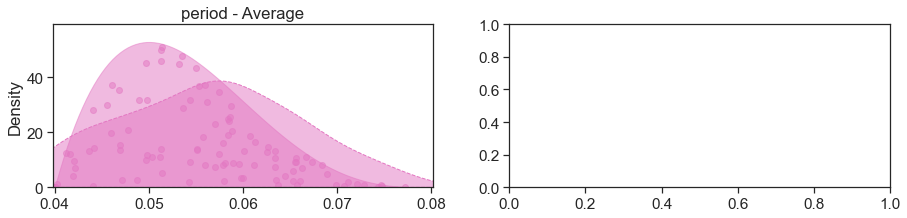

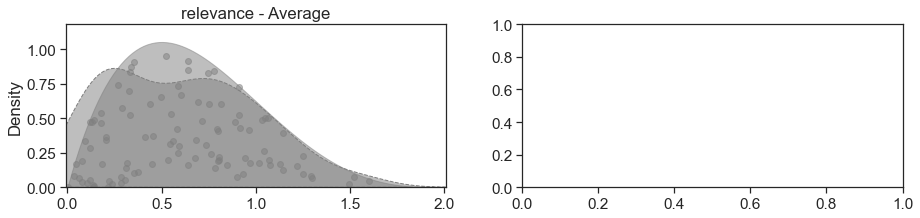

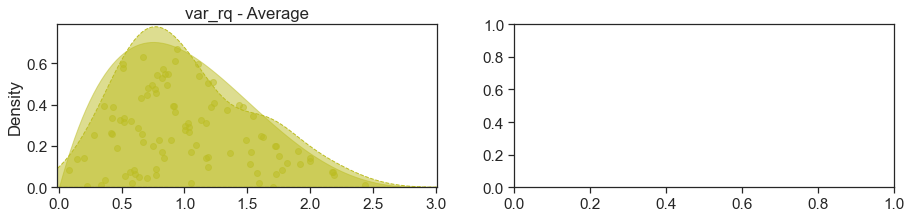

In [35]:
train(tgp)

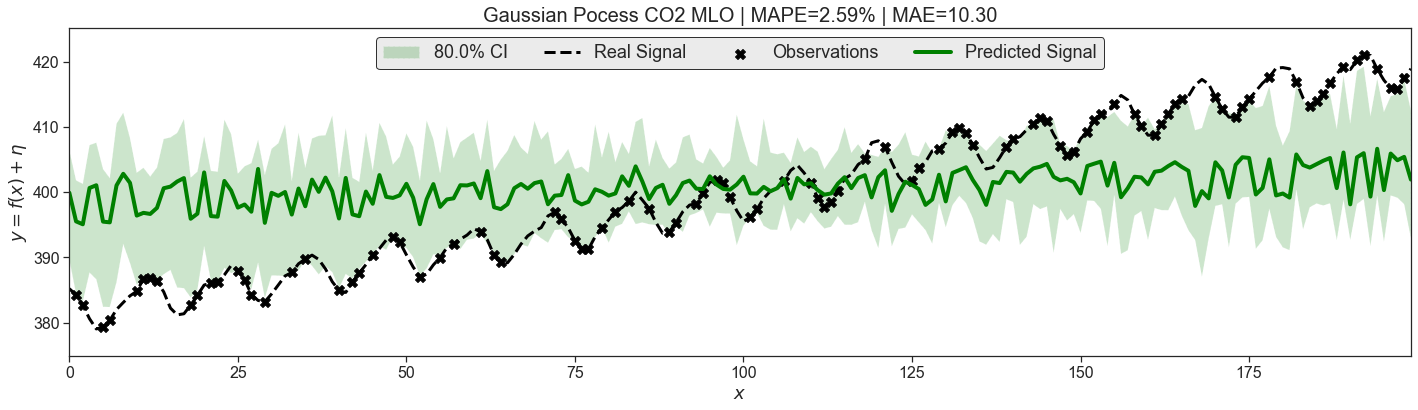

In [36]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', nsamples=1, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

## Kernel Composition

### SIN*SE + POL

In [44]:
#SIN*SE + POL 
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)

    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [45]:
tgp = model(CO2_monthly, train_index)

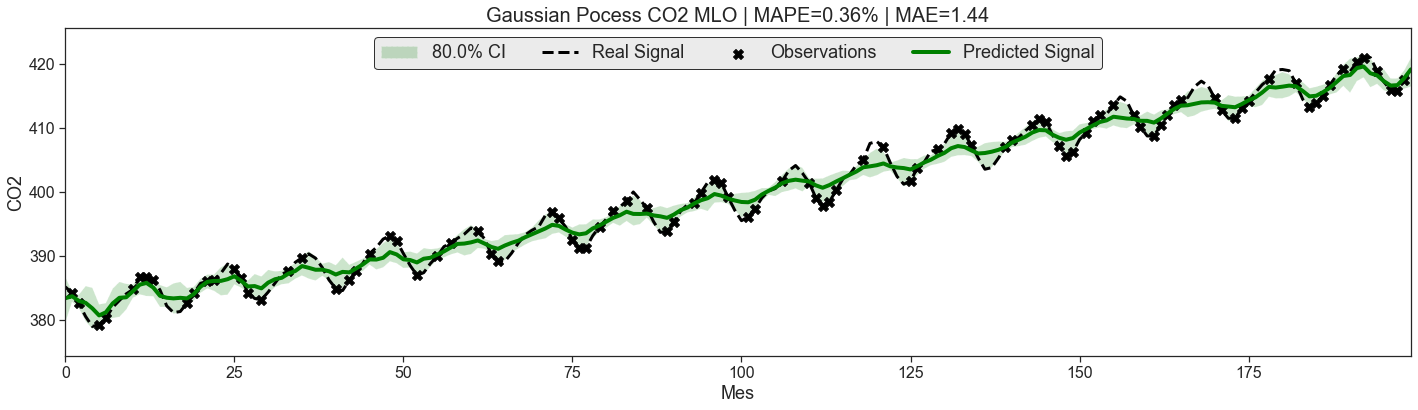

In [46]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True, samples_kwargs = {'alpha':0.1})

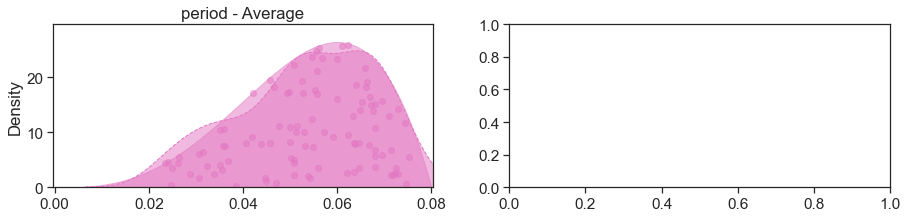

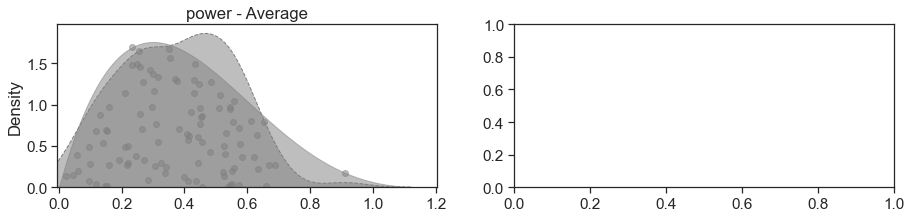

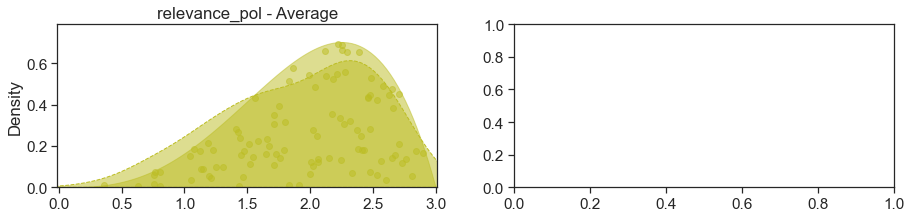

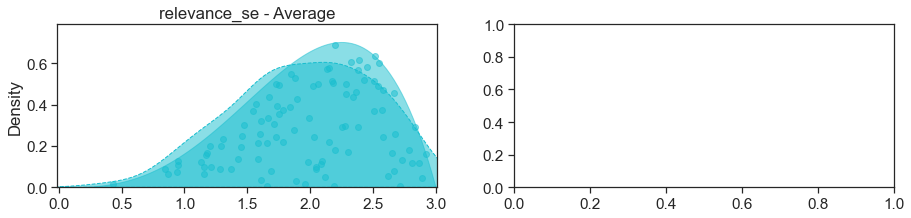

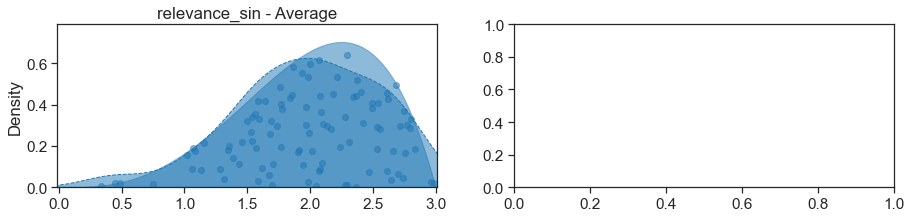

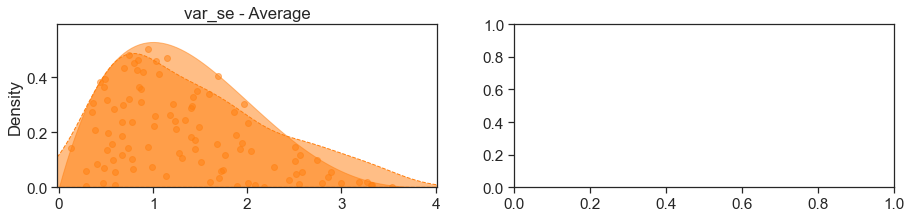

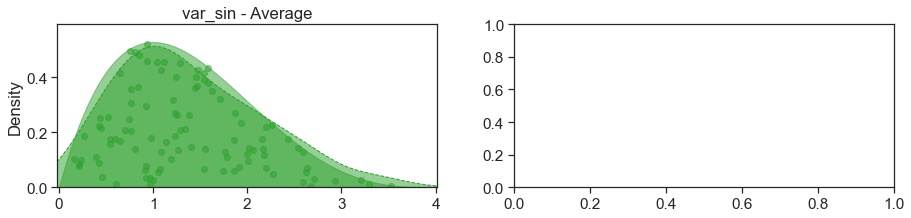

  0%|                                                                                                         …

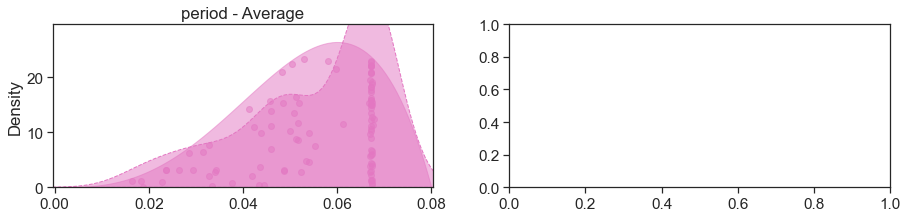

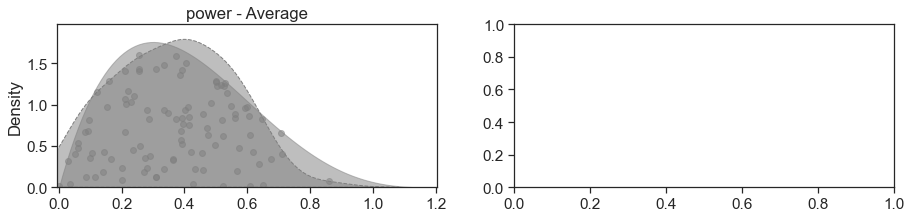

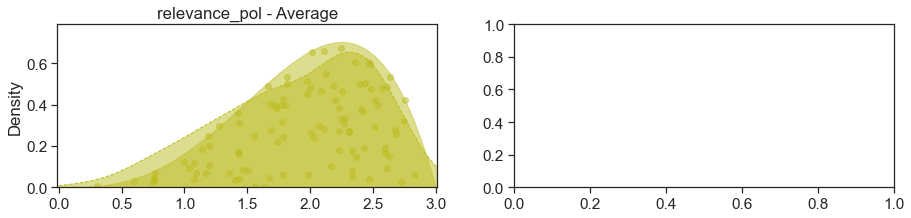

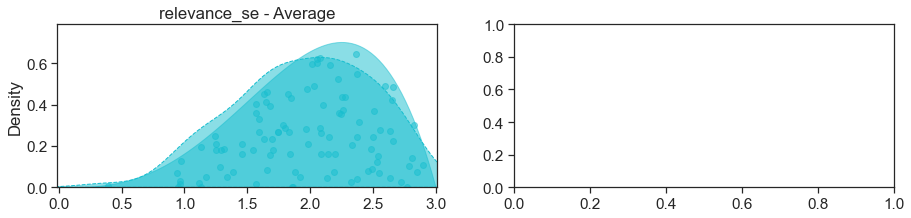

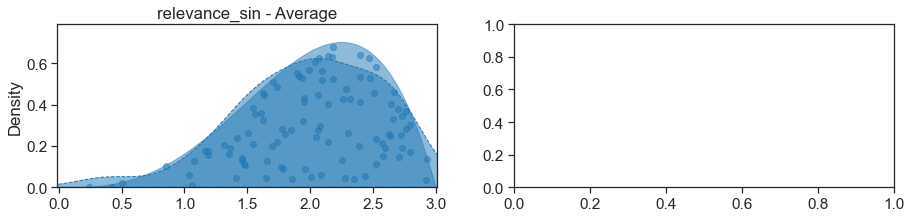

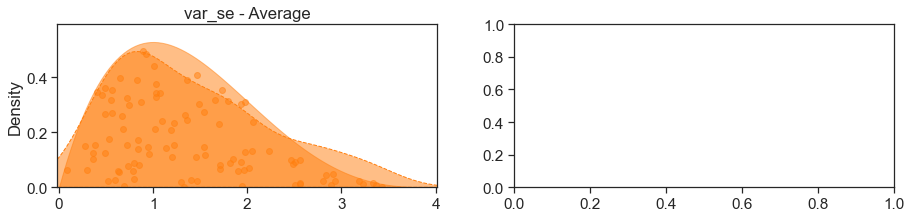

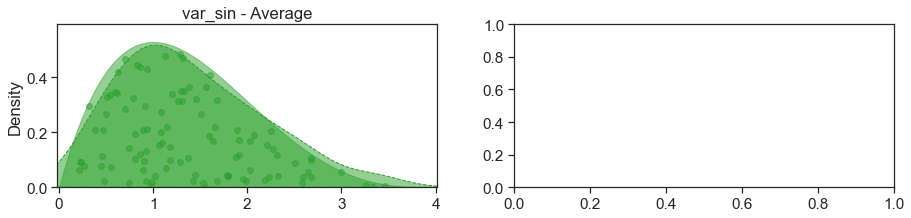

In [47]:
train(tgp)

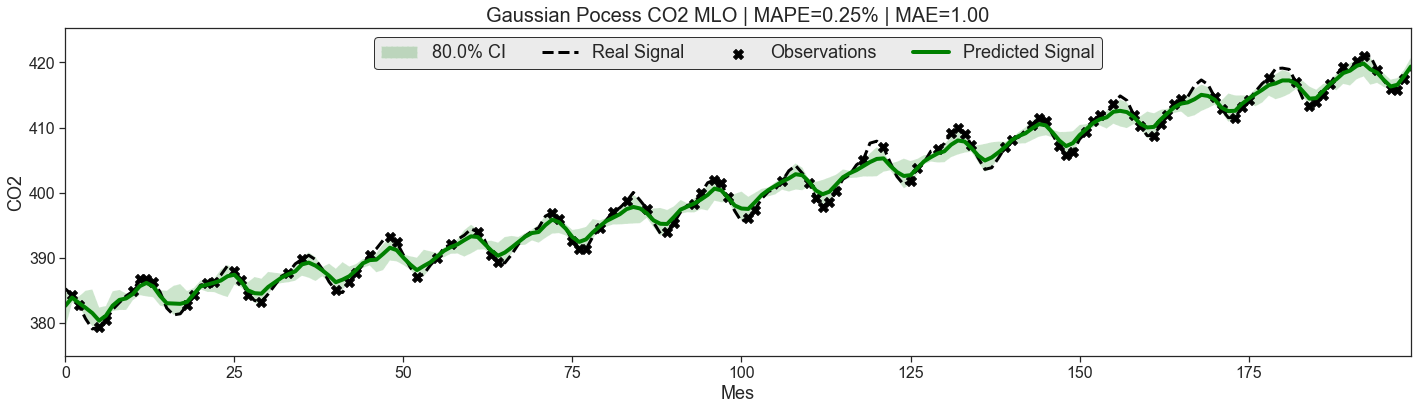

In [48]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True)

### SIN*RQ + POL

In [49]:
#SIN*RQ + POL 
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_rq = tg.TgPrior('var_rq', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_rq = tg.TgPrior('relevance_rq', ['Average'], dim=dim, low=0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    SIN = tg.SIN(var_sin, relevance_sin, period)
    RQ = tg.RQ(var_rq, relevance_rq, freedom)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, RQ)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)

    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [50]:
tgp = model(CO2_monthly, train_index)

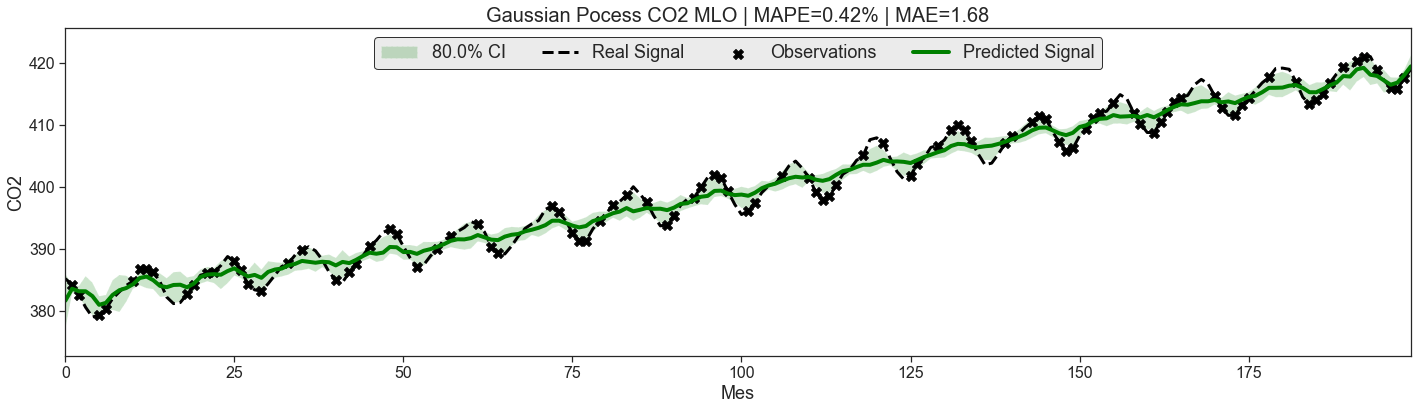

In [51]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True)

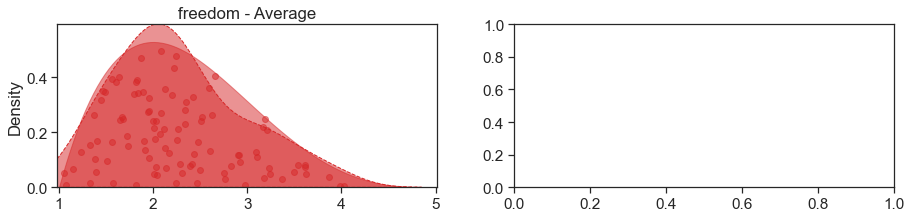

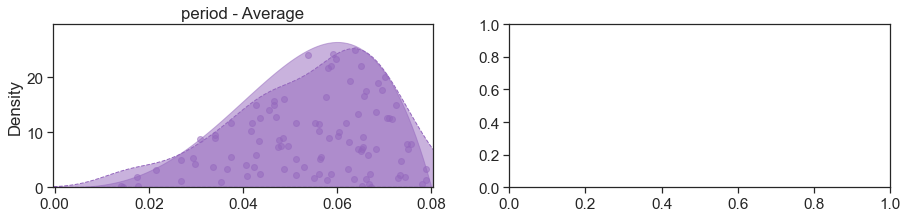

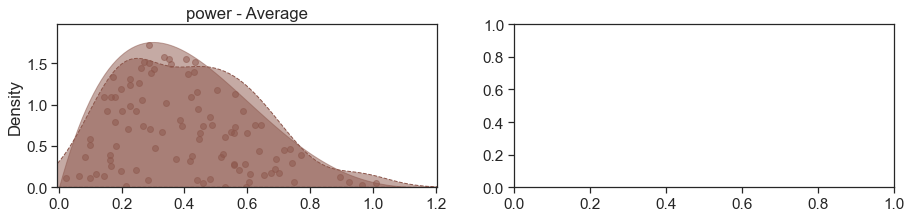

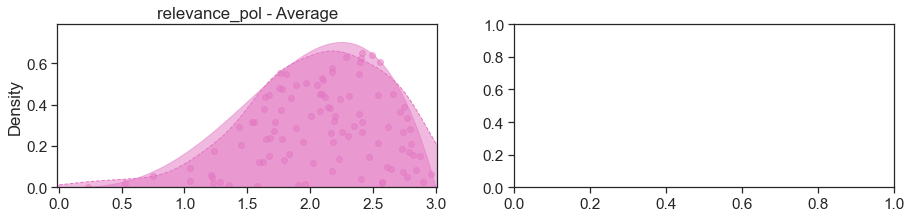

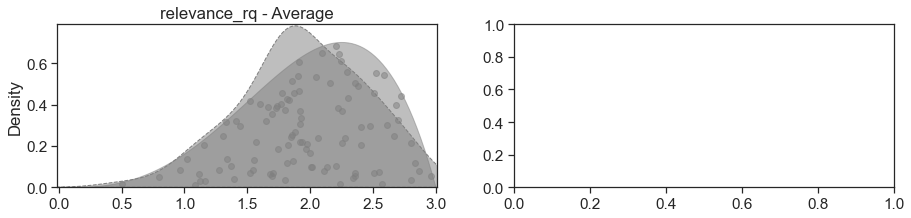

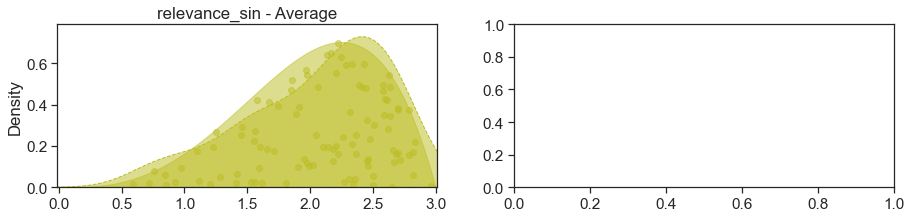

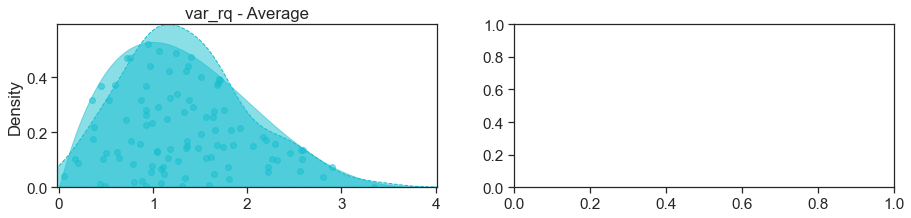

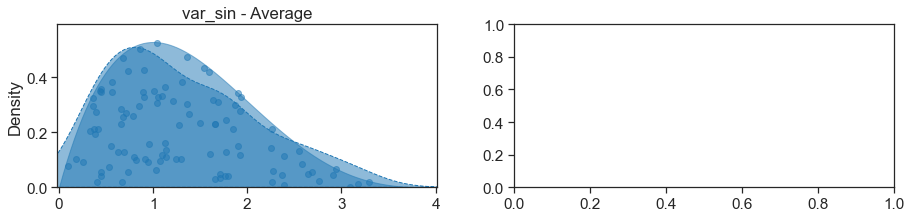

  0%|                                                                                                         …

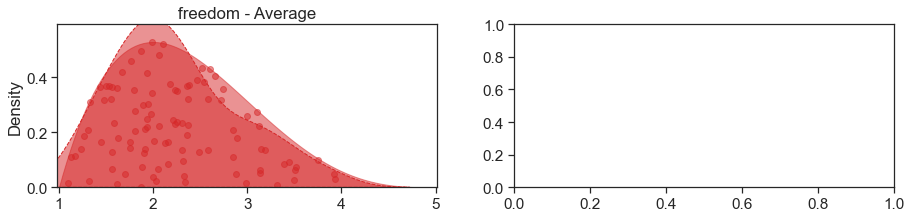

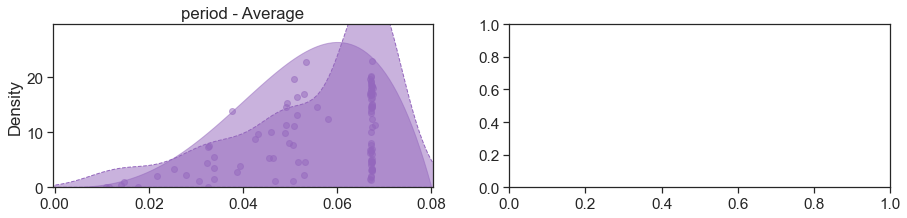

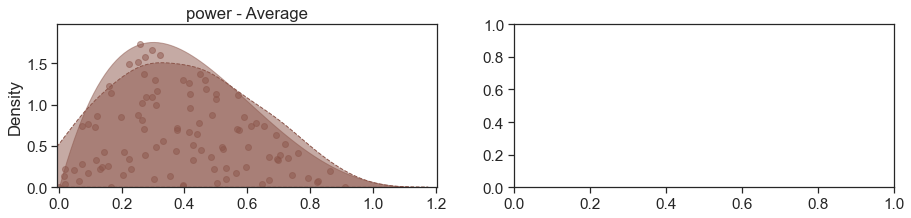

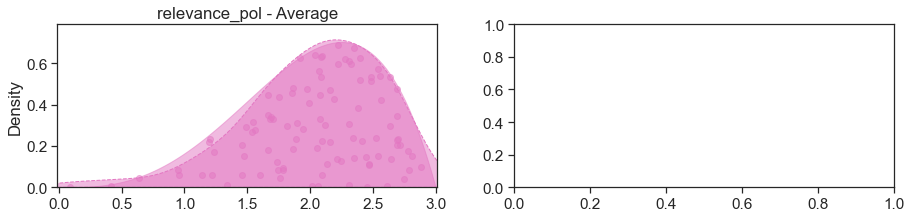

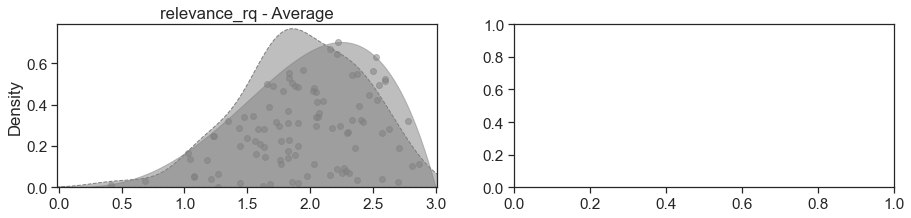

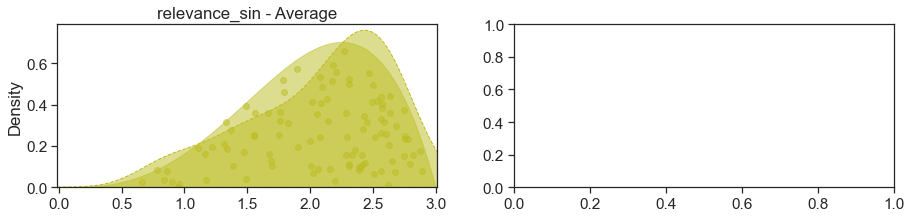

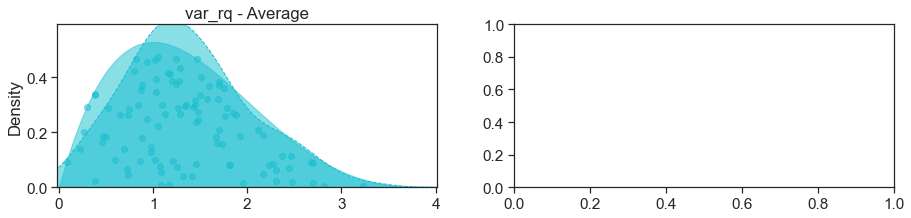

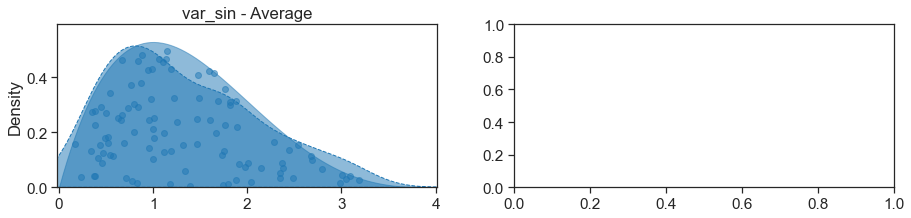

In [52]:
train(tgp)

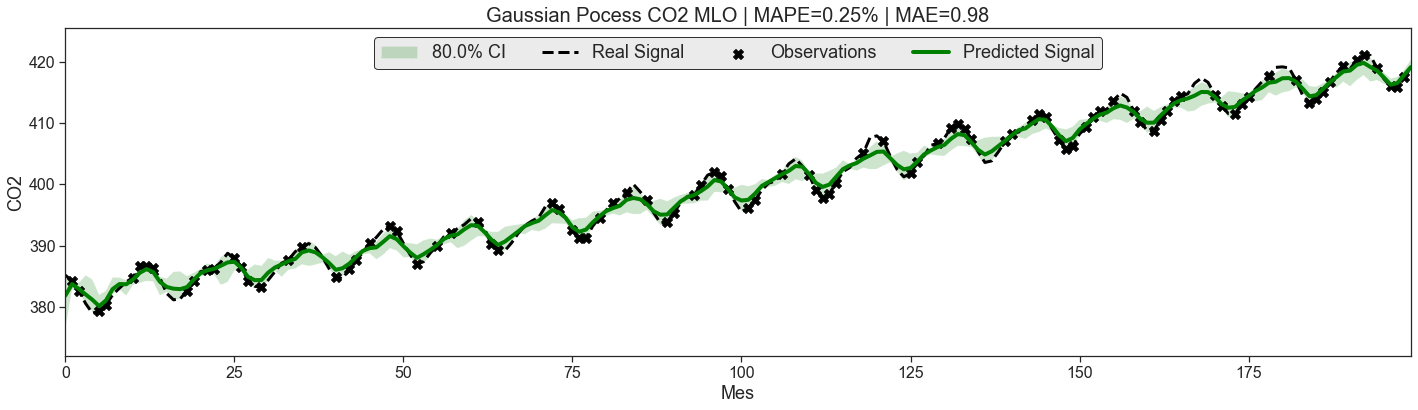

In [53]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True, samples_kwargs = {'alpha':0.1})

### SM*SE + POL

In [76]:
#SM*SE + POL
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=3, beta=4)
    var_sm  = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4)

    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_sm = tg.TgPrior('relevance_sm', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    
    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
 
    SE = tg.SE(var_se, relevance_se)
    SM = tg.SM(var_sm, relevance_sm, period)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SM, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [77]:
tgp = model(CO2_monthly, train_index)

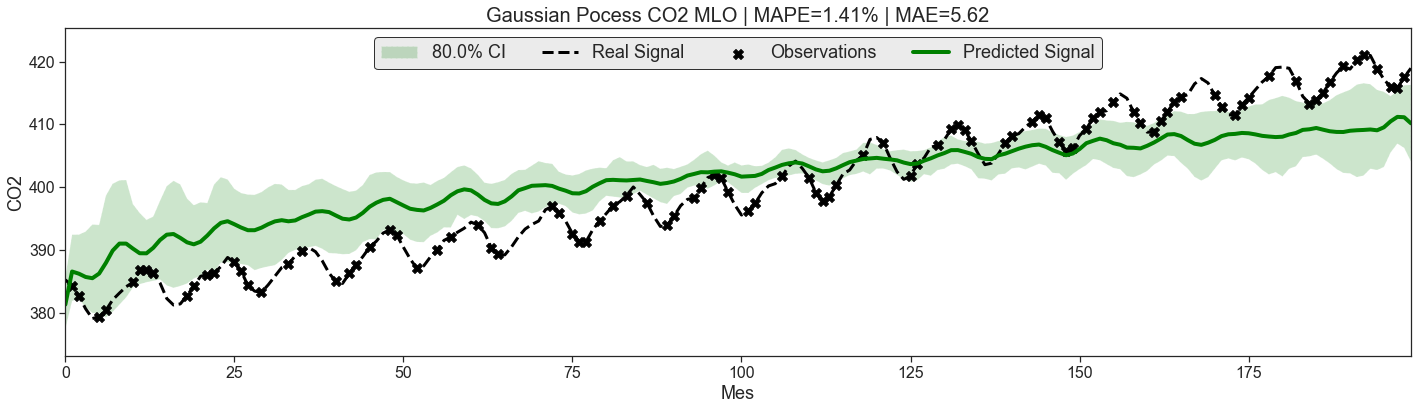

In [78]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True, samples_kwargs = {'alpha':0.1})

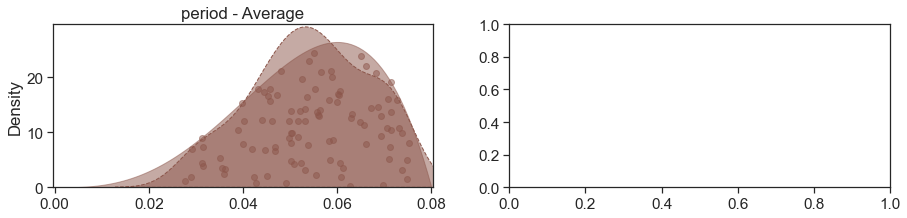

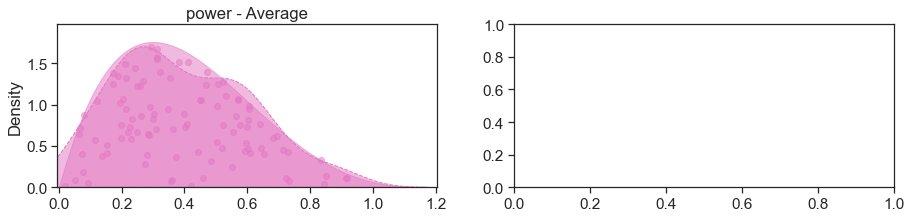

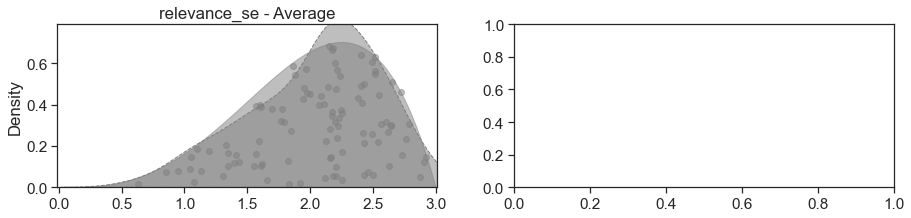

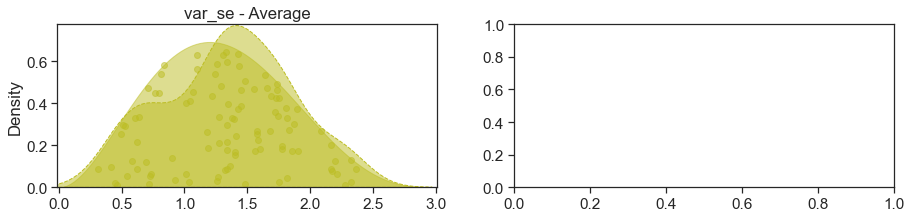

  0%|                                                                                                         …

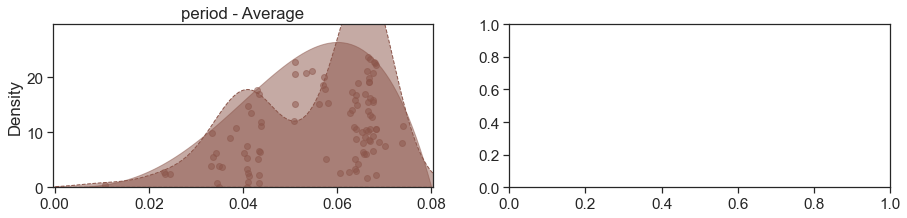

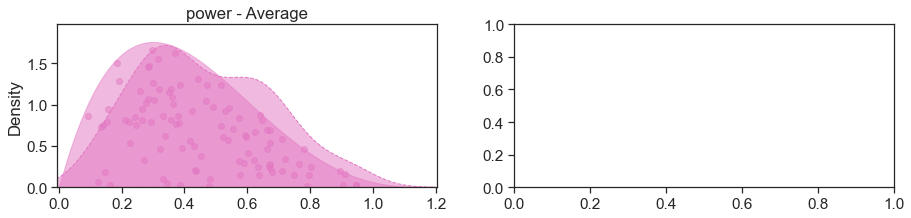

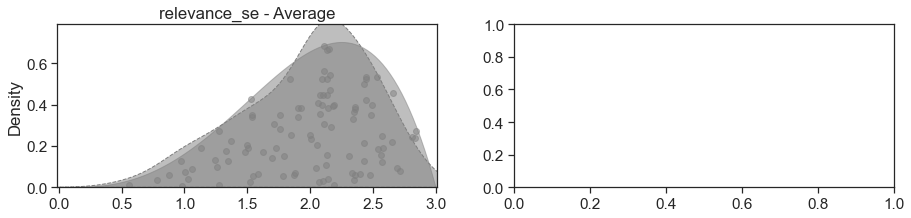

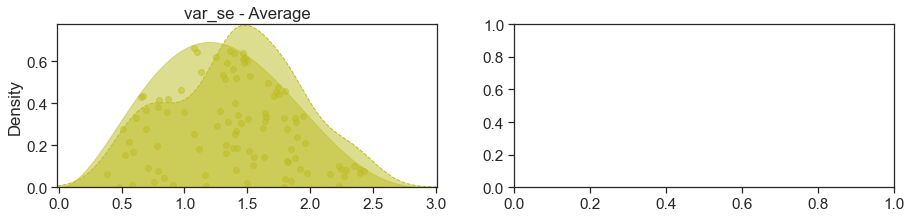

In [79]:
train(tgp)

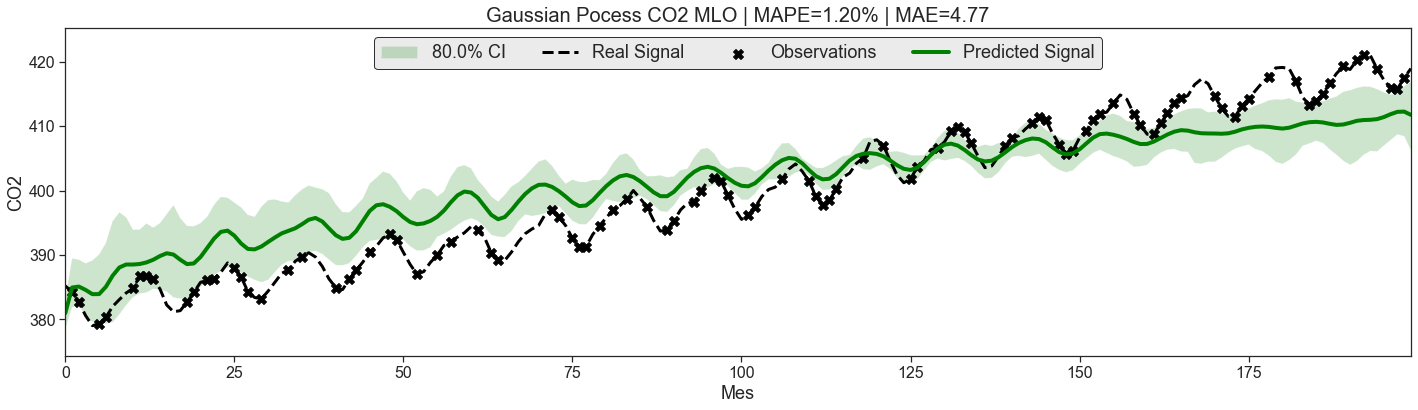

In [80]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True)

# Pruebas Modelos Extrapolación

In [127]:
t = CO2_monthly['index']
y = CO2_monthly['average']
particion = 0.7
obs_final = int(particion*len(t))
train_index = range(obs_final)
valid_index = range(obs_final,len(t) )
t_obs = t[train_index]
y_obs = y[train_index]
t_val = t[valid_index]
y_val = y[valid_index]

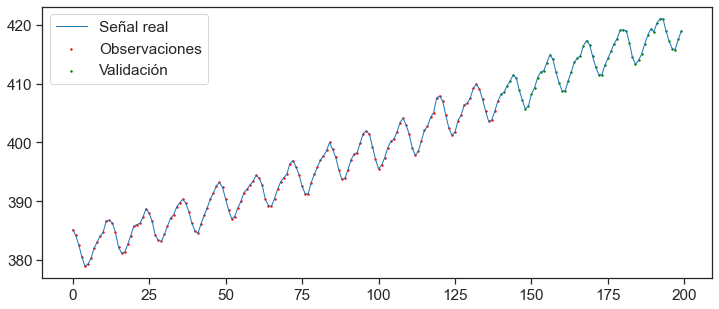

In [128]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.scatter(t_val, y_val, c='g', s = 2, label='Validación')
plt.legend()
plt.show()

## SIN*SE + POL

In [129]:
#SIN*SE + POL 
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)

    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [130]:
tgp = model(CO2_monthly, train_index)

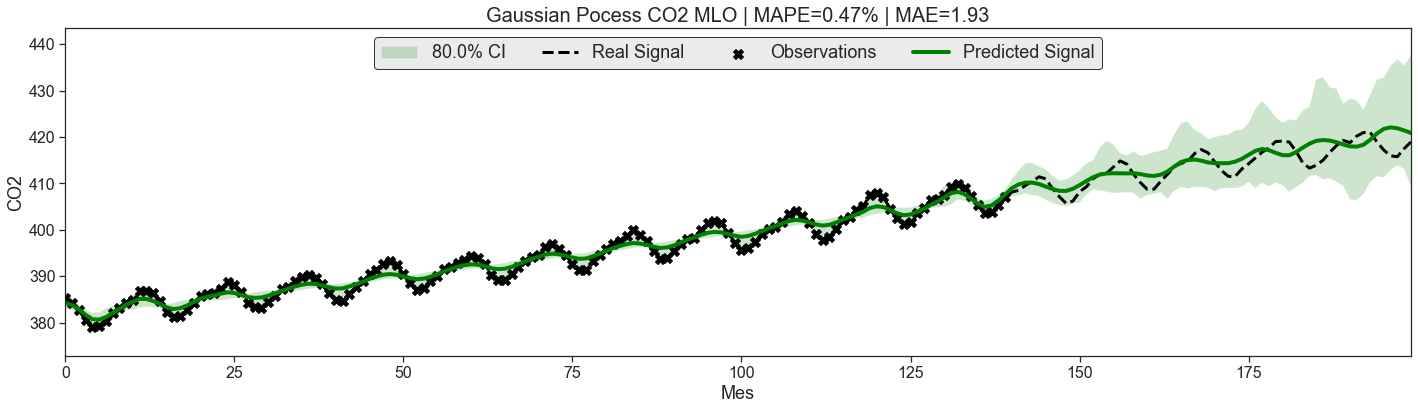

In [131]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True)

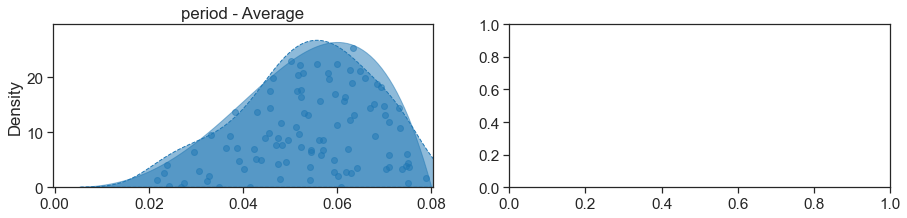

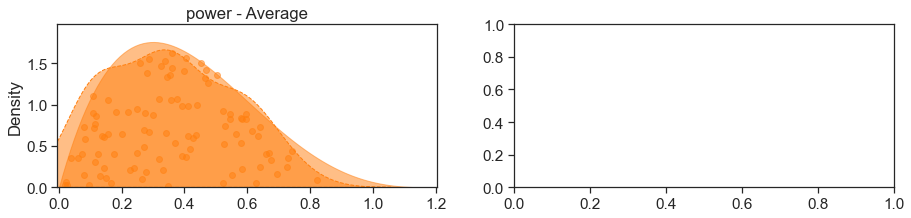

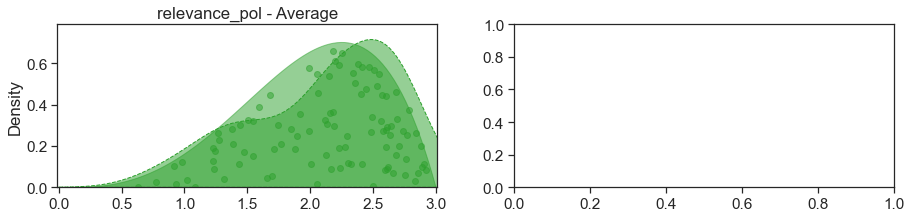

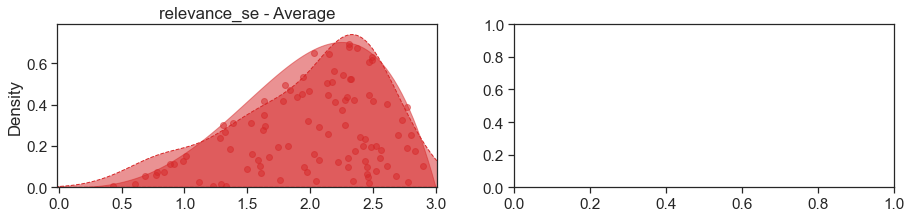

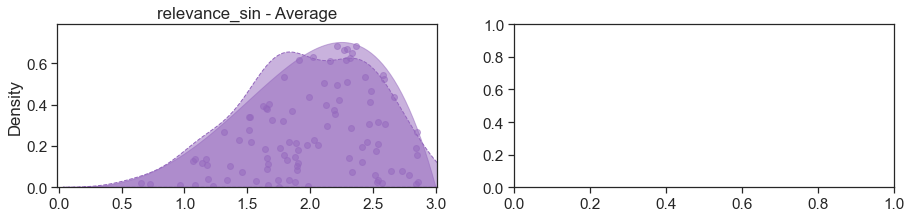

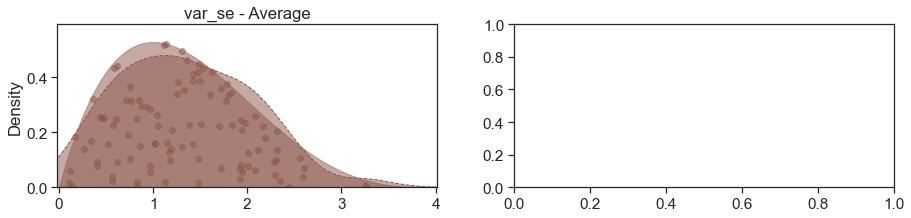

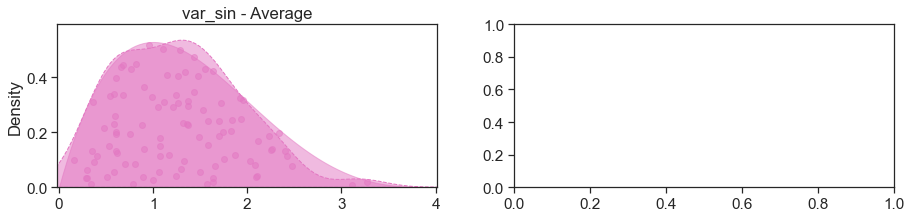

  0%|                                                                                                         …

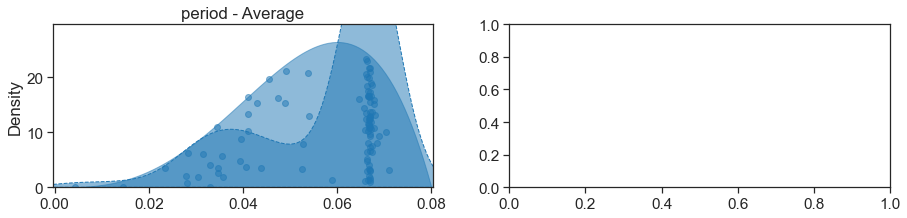

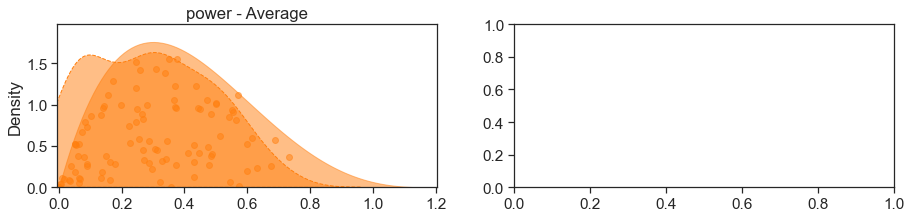

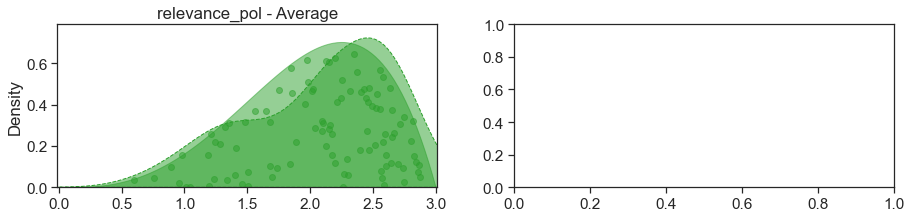

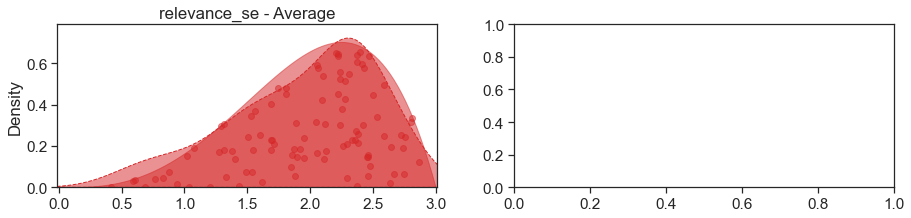

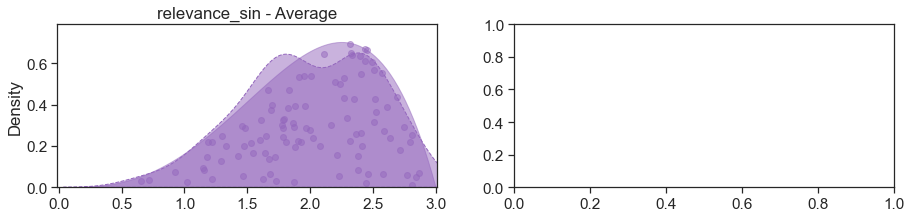

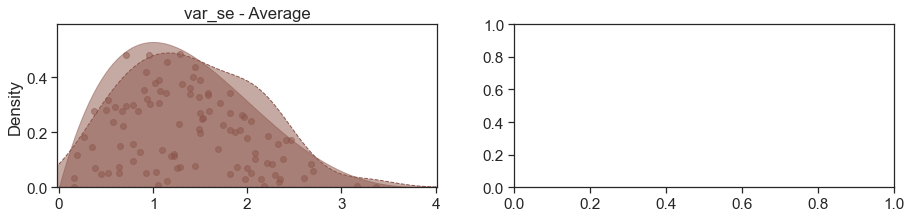

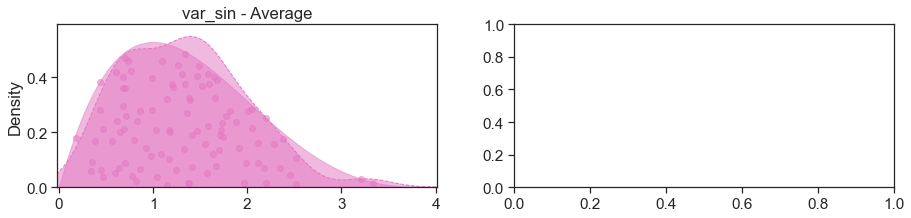

In [132]:
train(tgp)

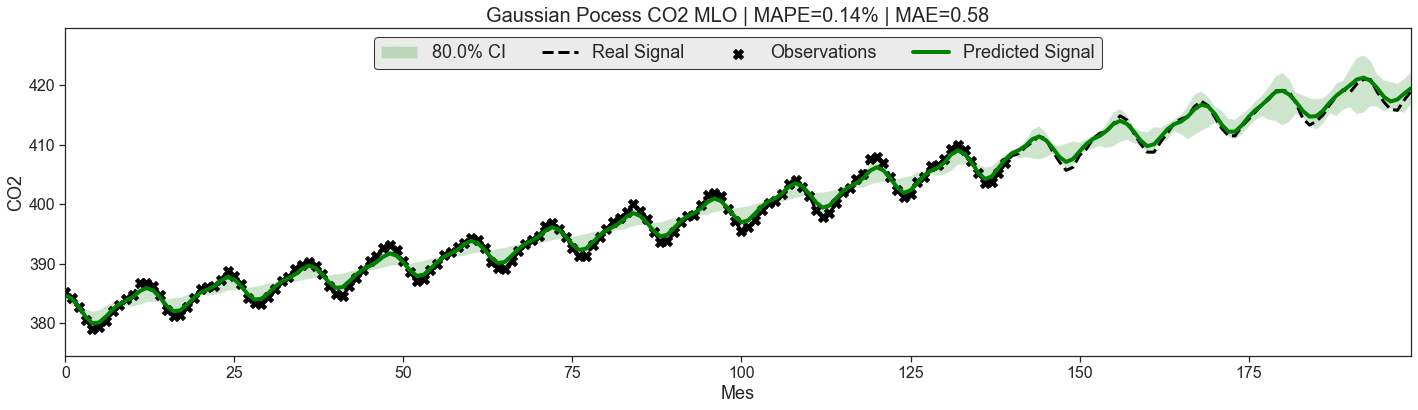

In [133]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples = False, 
                 noise = True)

## SIN*SE + SE

In [134]:
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=3, beta=4)
    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4)
    var_se_sum = tg.TgPrior('var_se_sum', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4)
    
   
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    relevance_se_sum = tg.TgPrior('relevance_se_sum', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    
    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    noise = tg.TgPrior('noise', ['Average'], dim=dim, low=0.0, high=0.05, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    SE_sum = tg.SE(var_se_sum, relevance_se_sum)

    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, SE_sum)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [135]:
tgp = model(CO2_monthly, train_index)

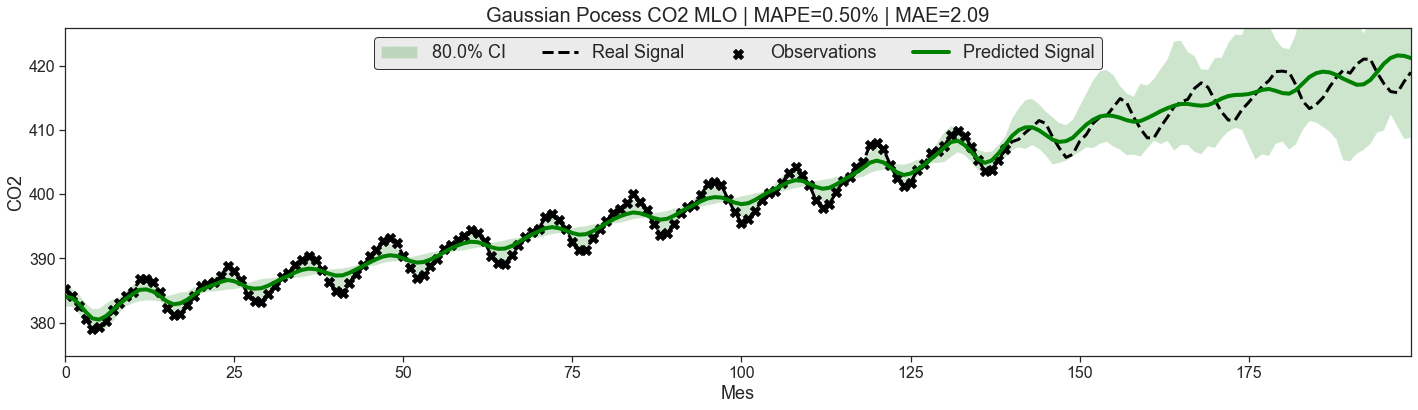

In [136]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, ylim_by_CI=False)

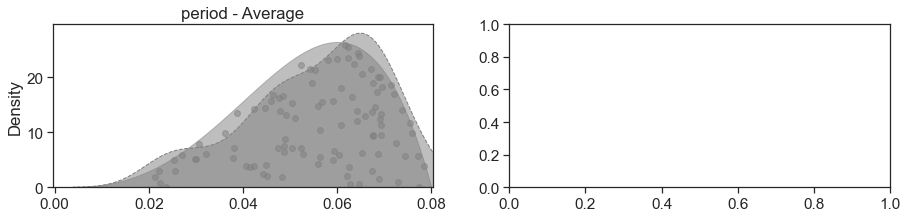

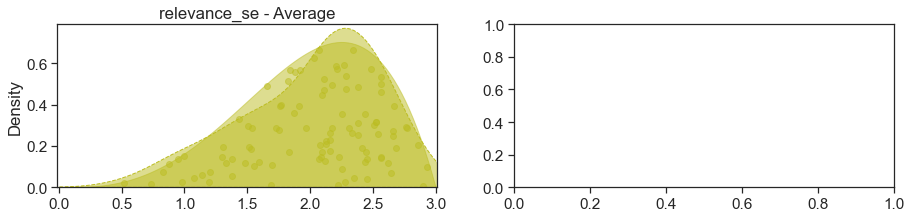

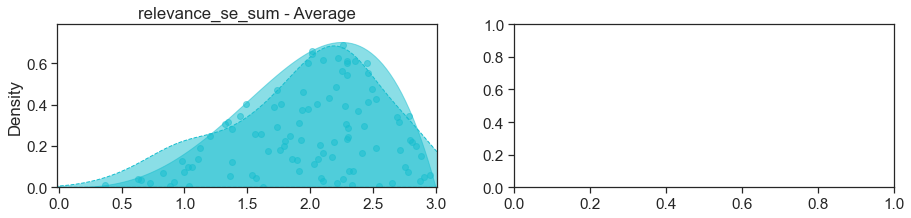

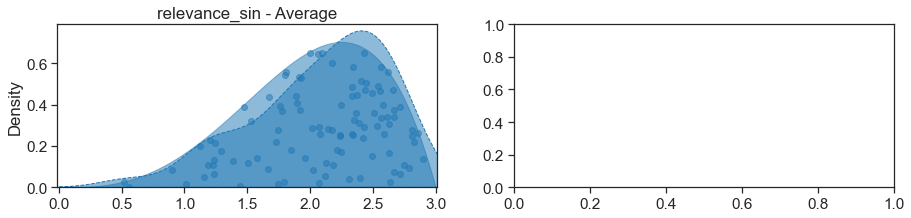

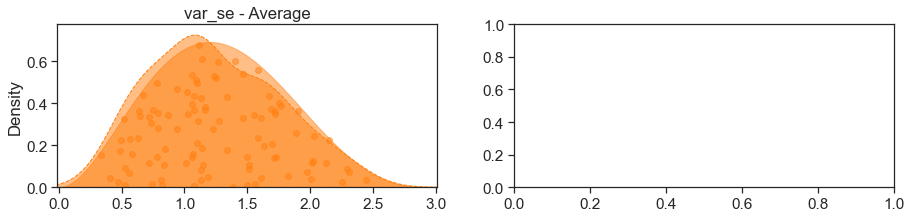

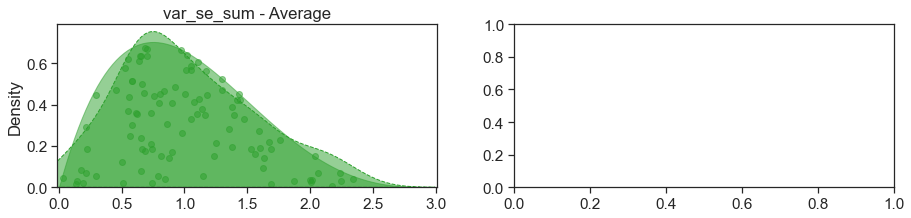

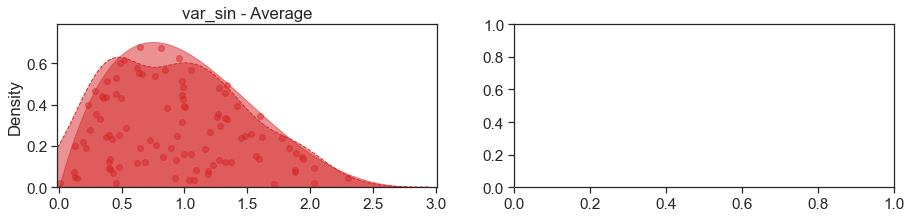

  0%|                                                                                                         …

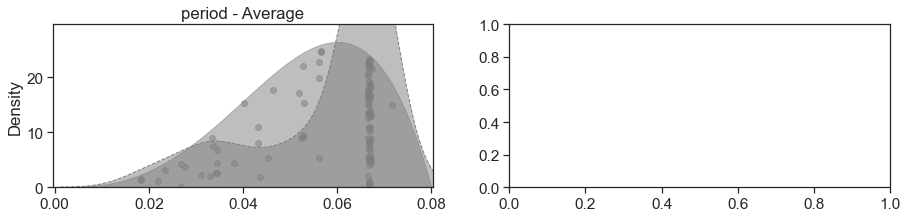

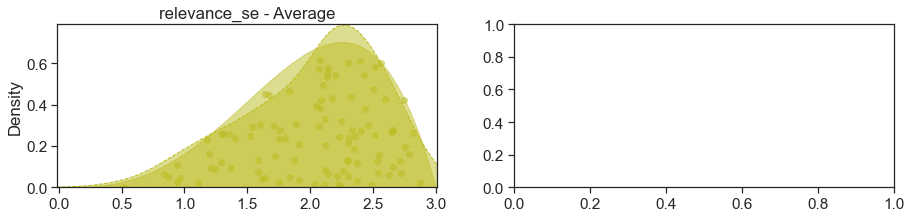

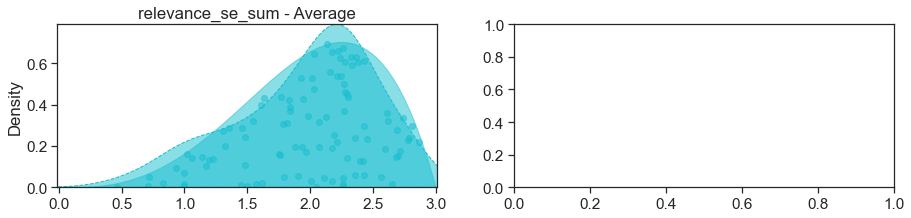

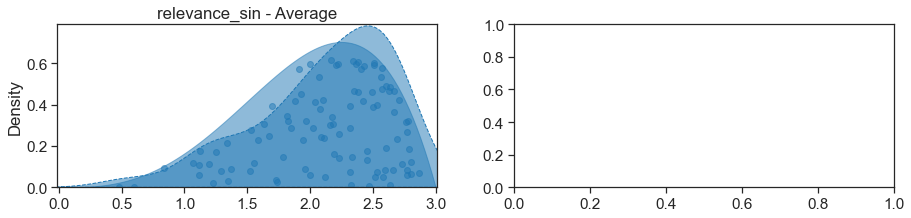

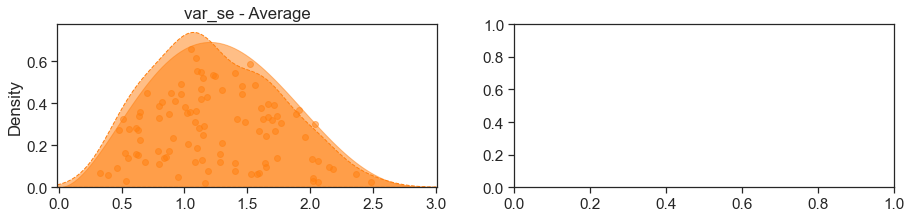

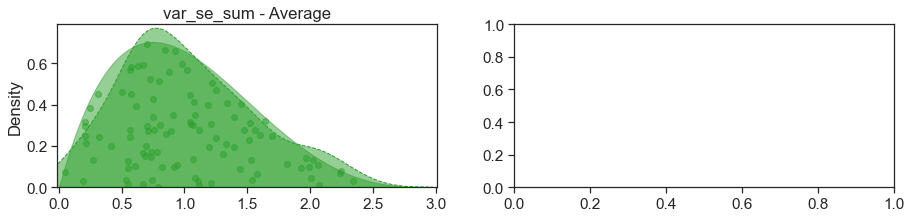

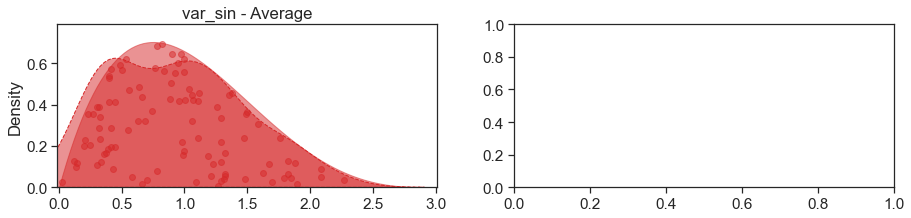

In [137]:
train(tgp)

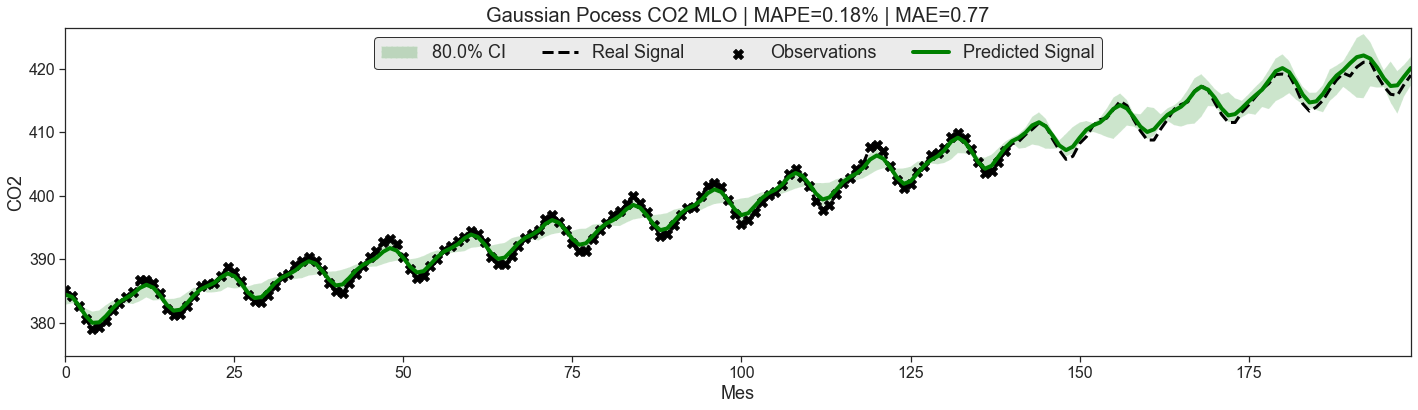

In [138]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, ylim_by_CI=False)

## SM*SE + SE

In [70]:
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=3, beta=4)
    var_sm  = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4)
    var_se_sum = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=3, alpha=2, beta=4)
    
   
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_sm = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    relevance_se_sum = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2)
    
    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0, high=0.08, alpha=4, beta=2)
    noise = tg.TgPrior('noise', ['Average'], dim=dim, low=0.0, high=0.05, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
 
    SE = tg.SE(var_se, relevance_se)
    SE_sum = tg.SE(var_se_sum, relevance_se_sum)
    SM = tg.SM(var_sm, relevance_sm, period)
    kernel_prod  = tg.KernelProd(SM, SE)
    kernel = tg.KernelSum(kernel_prod, SE_sum)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [71]:
tgp = model(CO2_monthly, train_index)

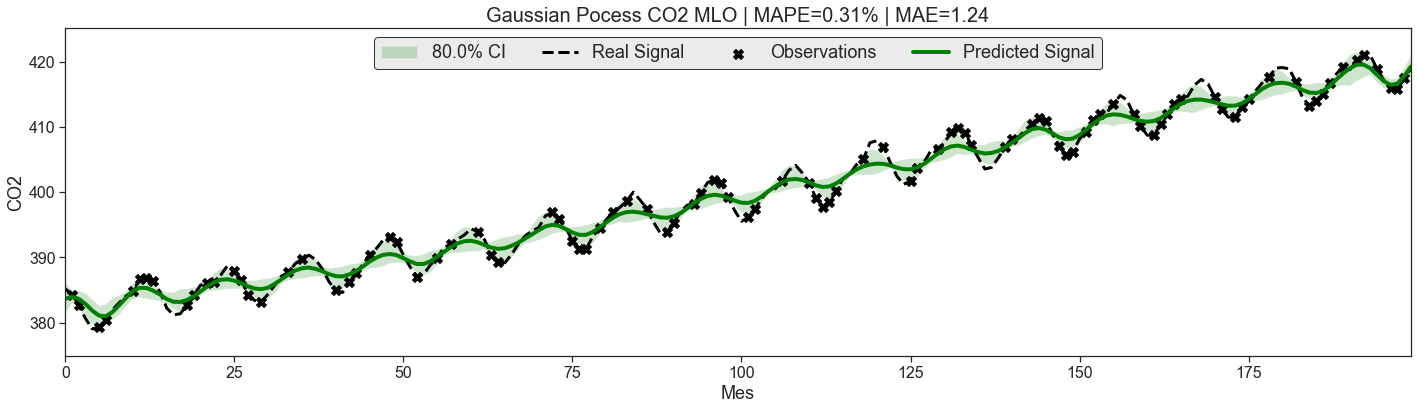

In [72]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

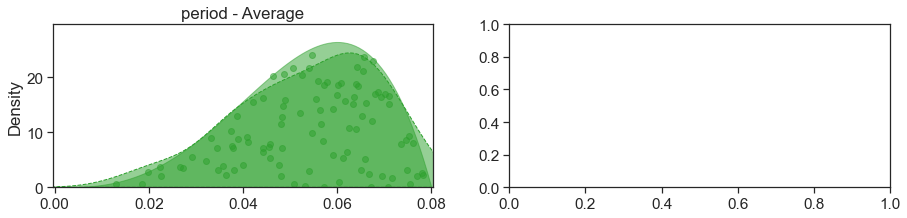

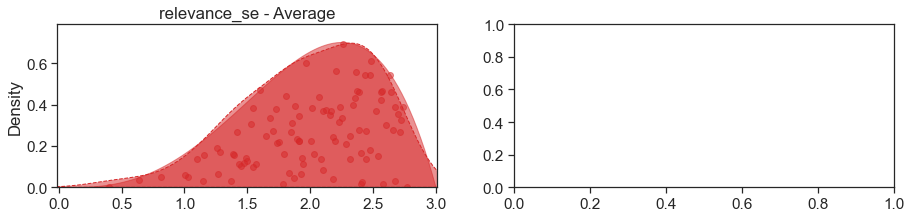

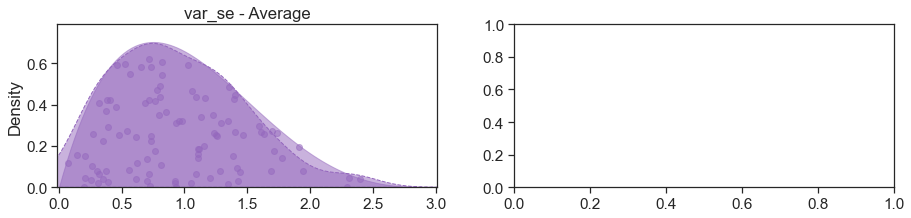

  0%|                                                                                                         …

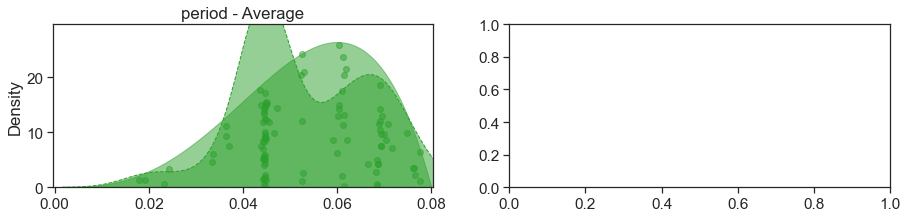

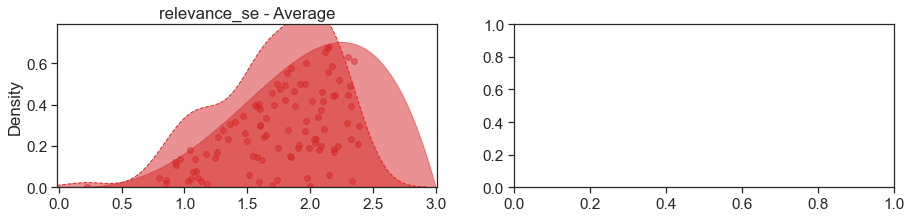

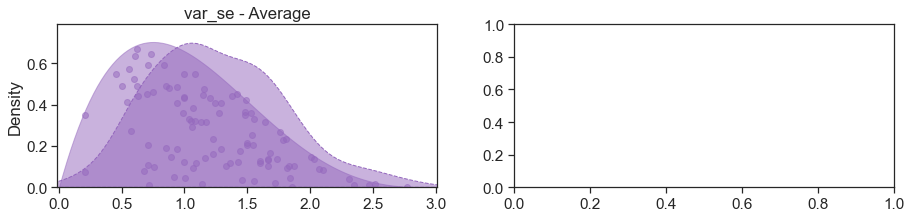

In [75]:
train(tgp)

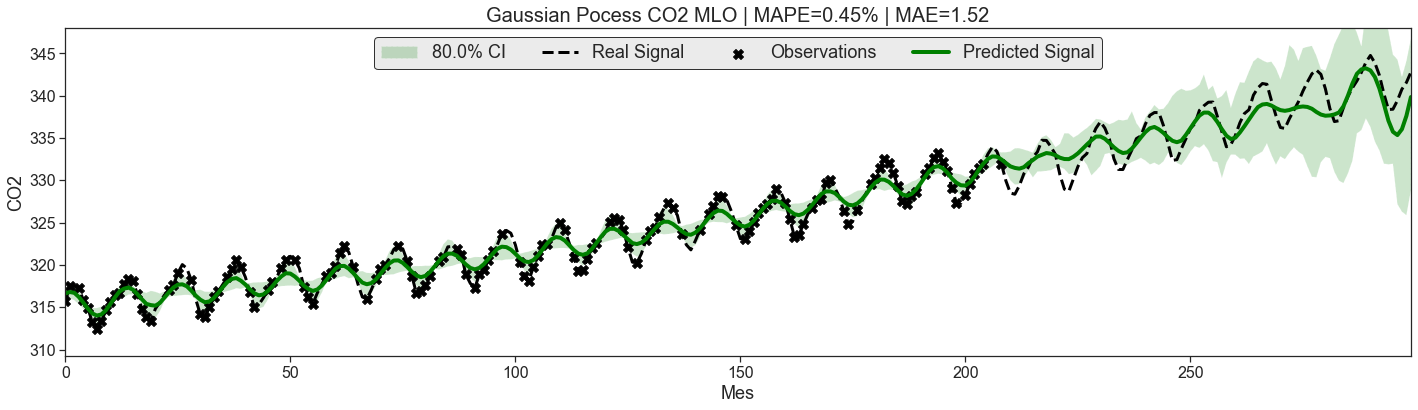

In [76]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

# Final Tests

In [140]:
np.random.seed(777)

In [161]:
#SIN*SE + POL 
def model(df, index_obs, dim = 100): 
    inputs = ['index']
    outputs = ['average']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0.04, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)

    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

## Interpolación

### 50% data

In [150]:
t = CO2_monthly['index']
y = CO2_monthly['average']
prop = 0.5
nobs = int(prop*len(t))
perm = tg.np.random.permutation(CO2_monthly.index)
train_index = np.sort(perm[:nobs])
valid_index = np.sort(perm[nobs:])
t_obs = t[train_index]
y_obs = y[train_index]

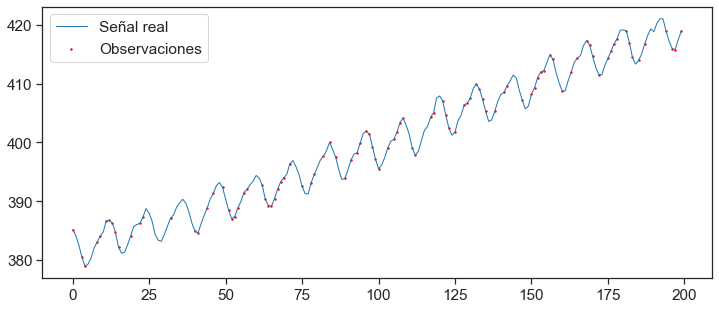

In [151]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.legend()
plt.show()

In [162]:
tgp = model(CO2_monthly, train_index)

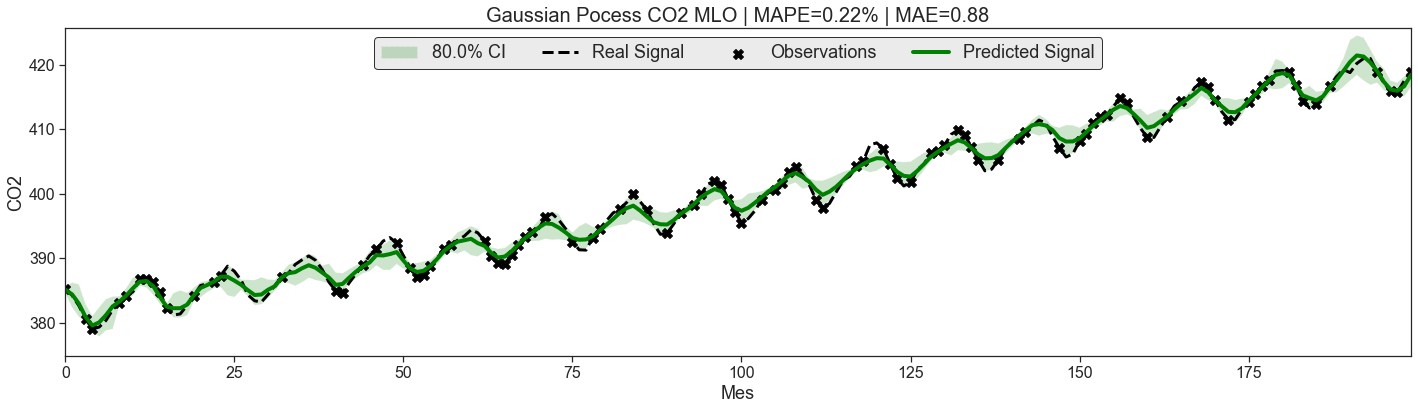

In [163]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

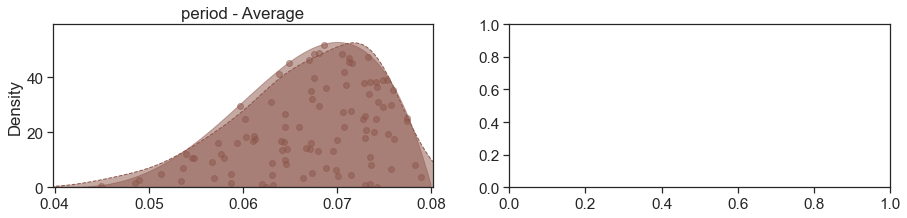

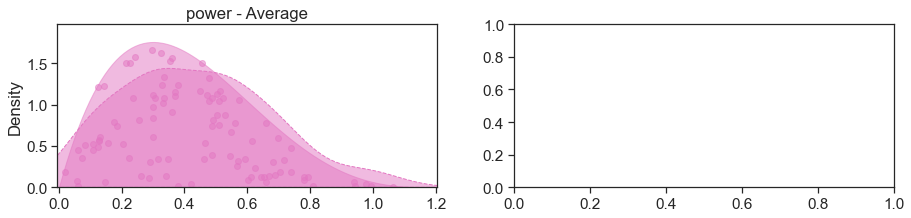

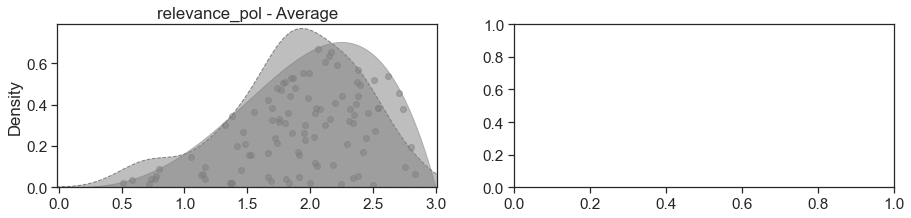

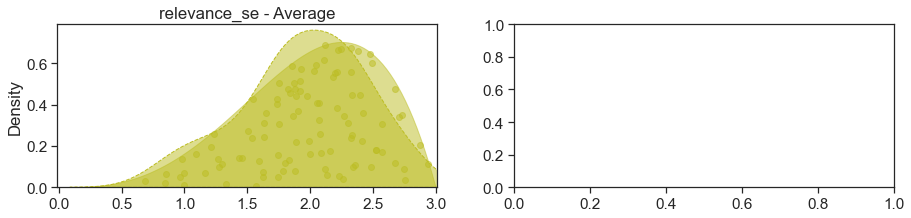

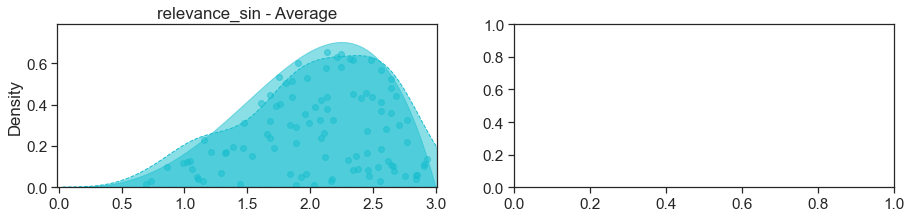

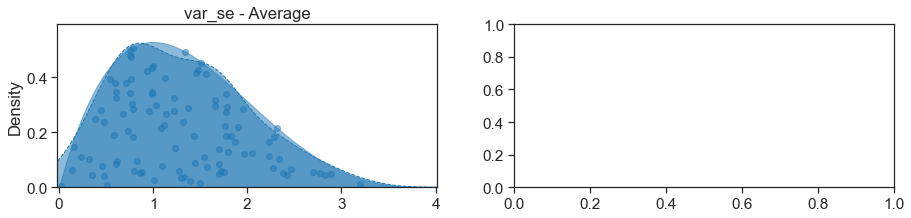

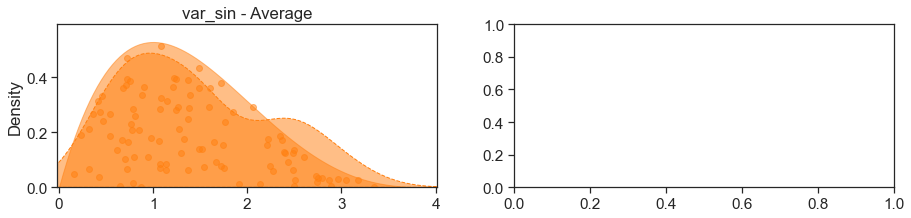

  0%|                                                                                                         …

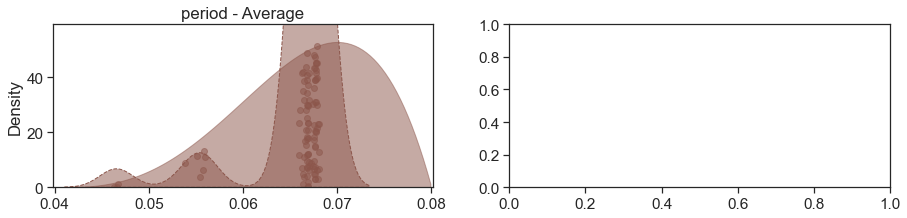

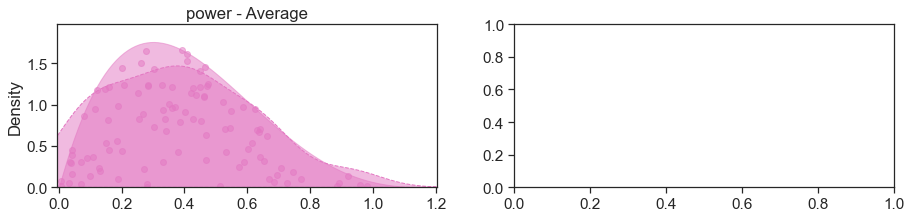

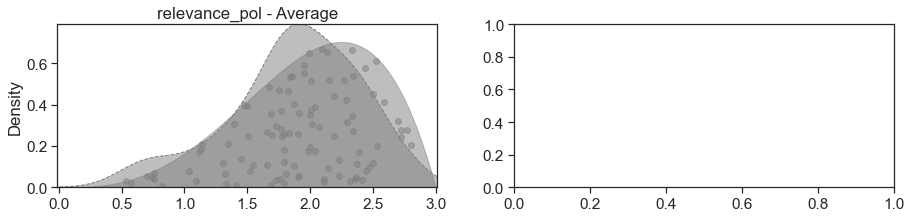

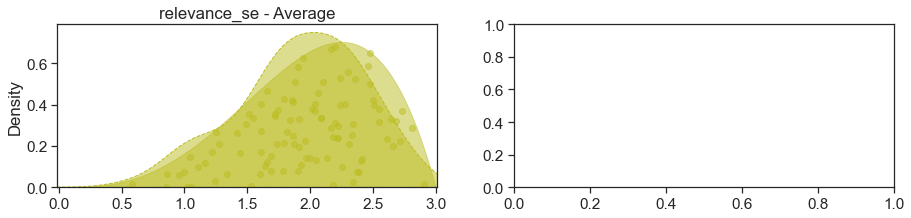

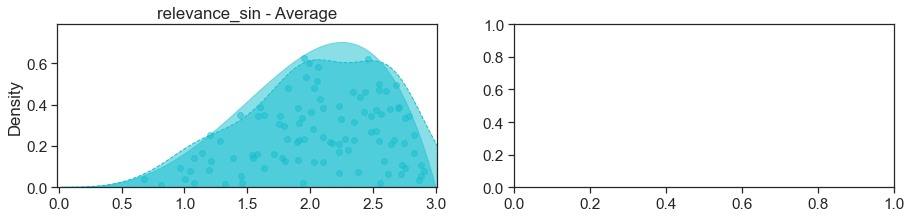

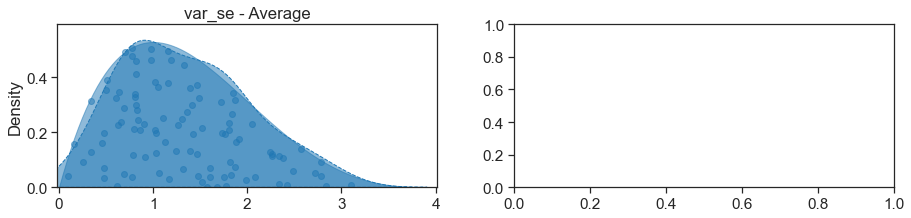

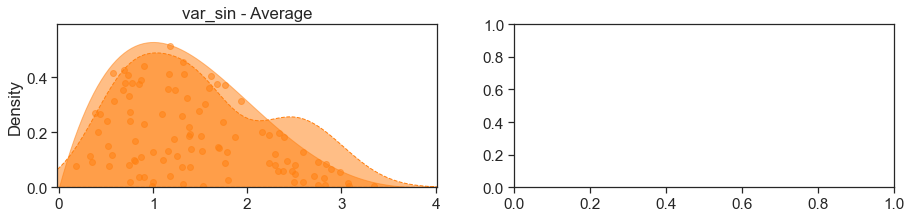

In [164]:
train(tgp)

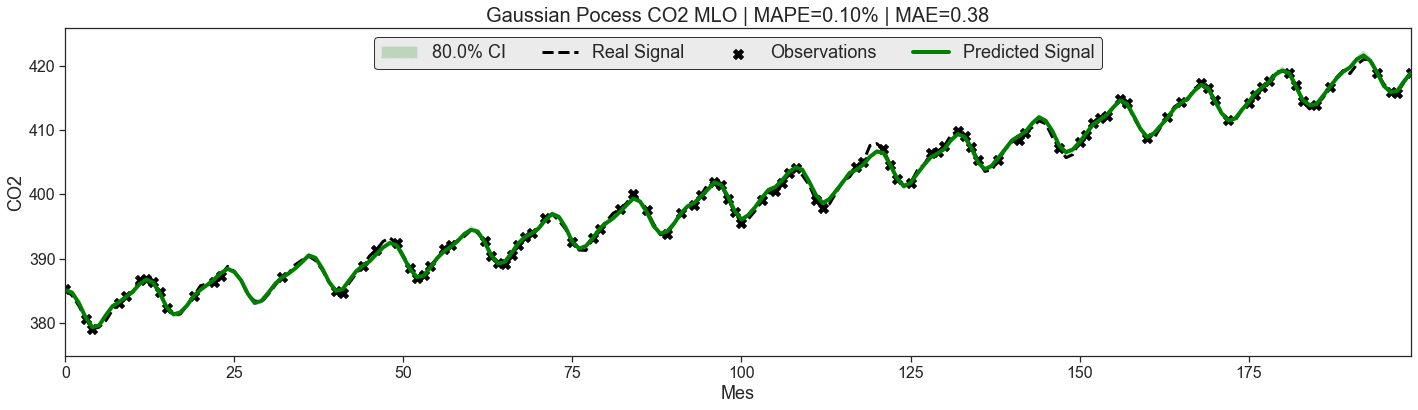

In [165]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

### 80% data

In [166]:
t = CO2_monthly['index']
y = CO2_monthly['average']
prop = 0.8
nobs = int(prop*len(t))
perm = tg.np.random.permutation(CO2_monthly.index)
train_index = np.sort(perm[:nobs])
valid_index = np.sort(perm[nobs:])
t_obs = t[train_index]
y_obs = y[train_index]

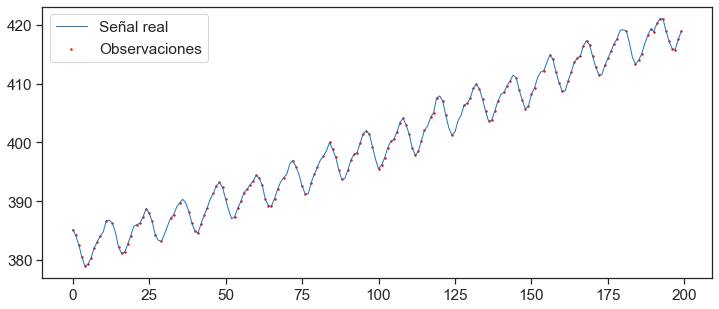

In [167]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.legend()
plt.show()

In [168]:
tgp = model(CO2_monthly, train_index)

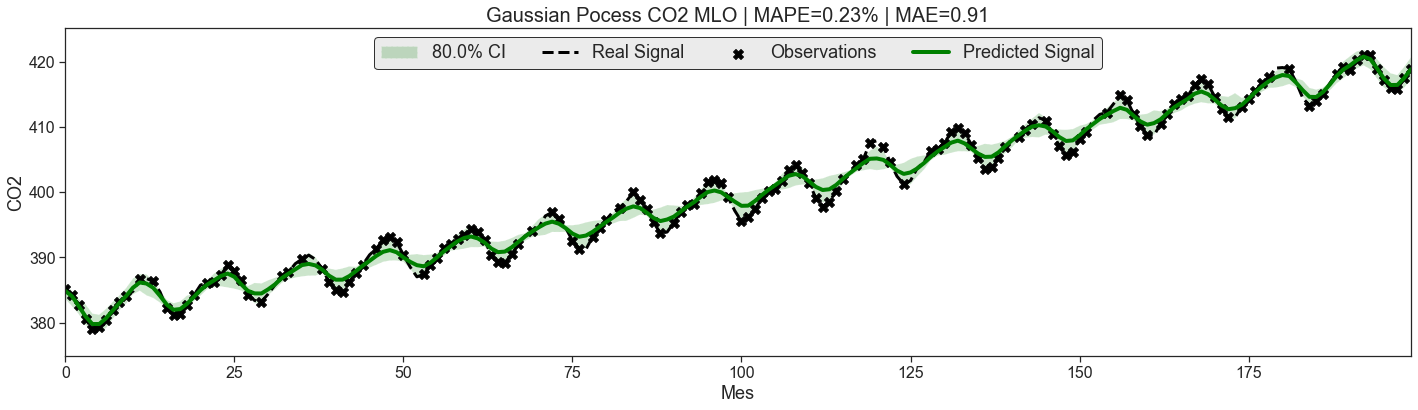

In [169]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

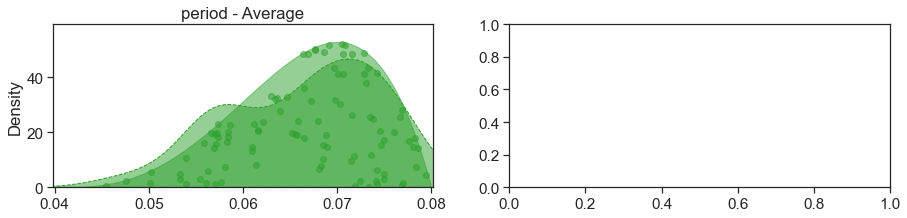

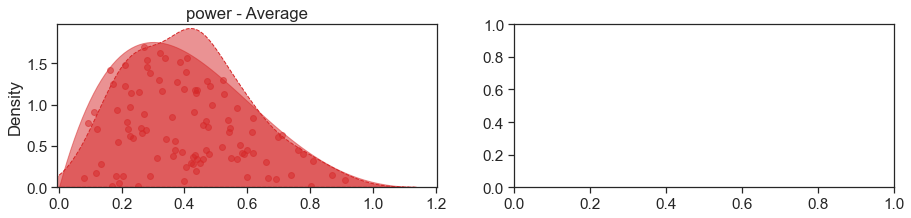

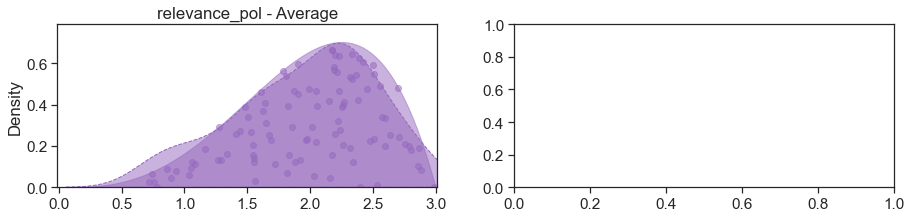

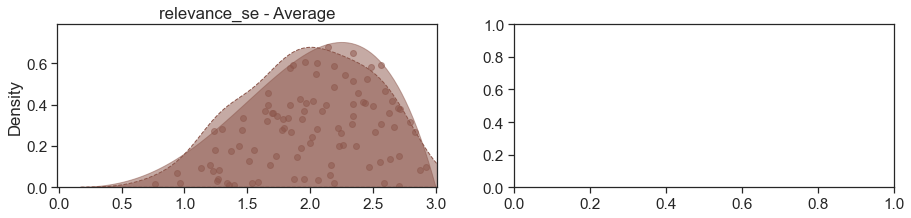

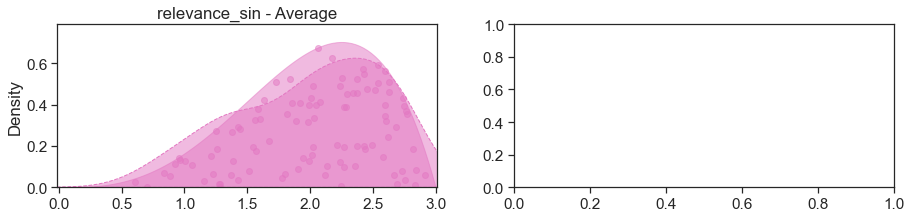

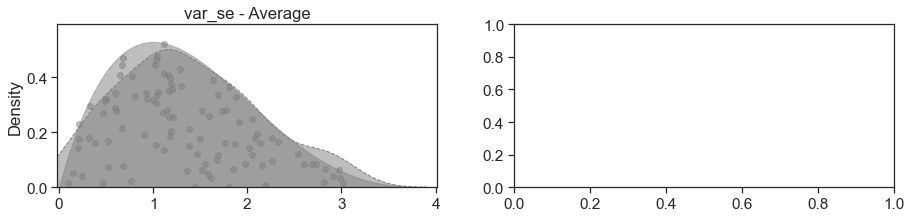

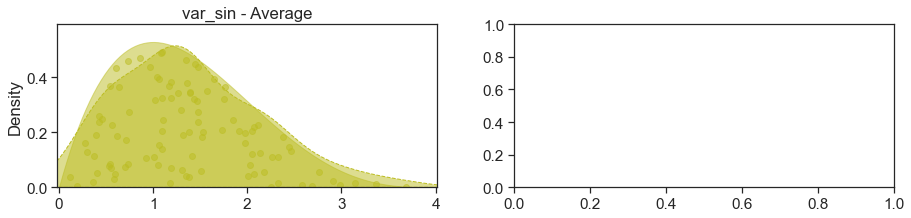

  0%|                                                                                                         …

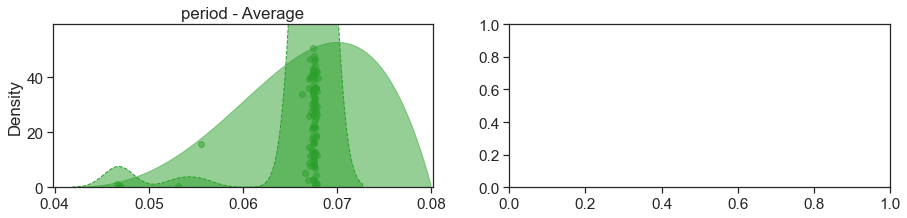

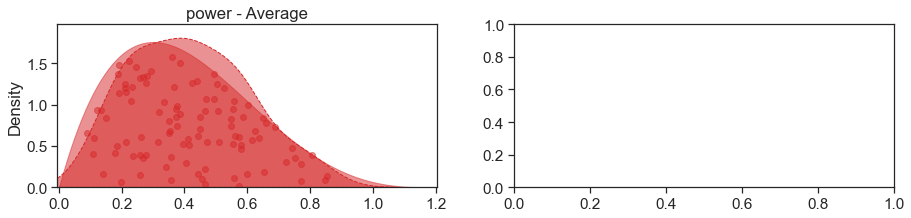

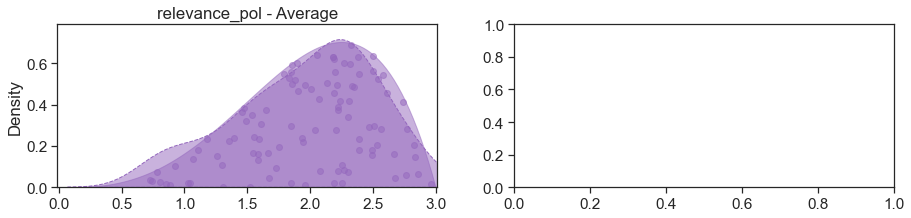

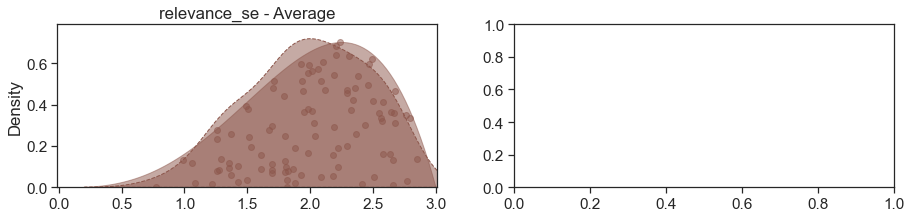

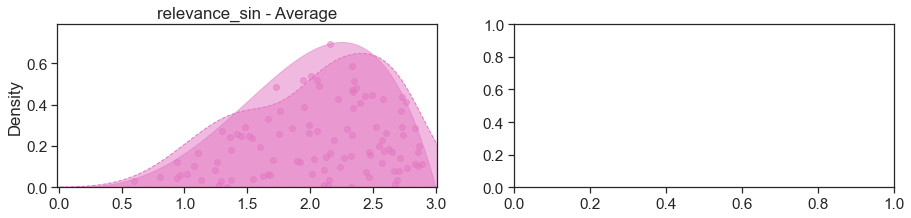

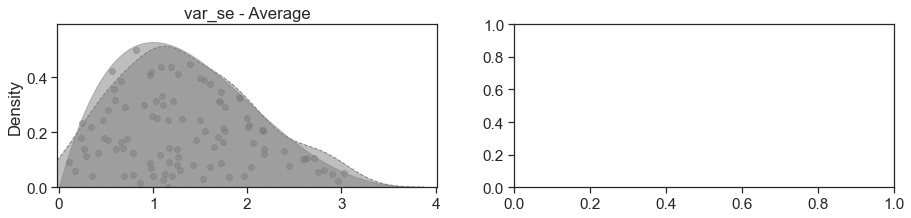

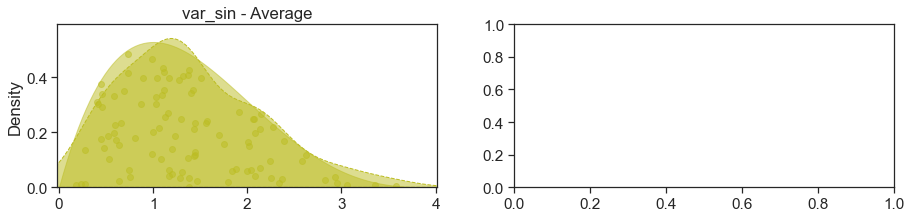

In [170]:
train(tgp)

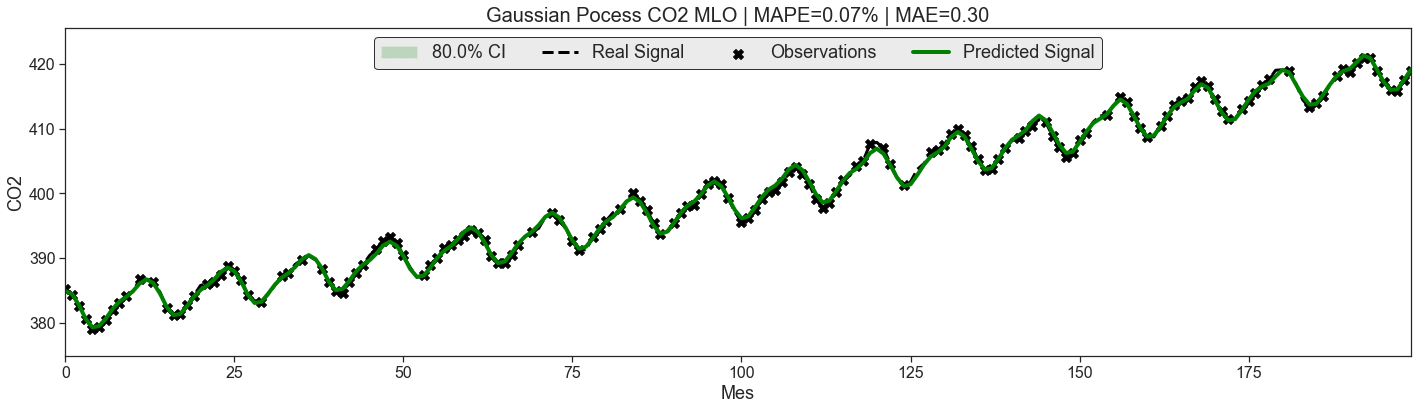

In [171]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

### Resumen

Experimento |MAPE|MAE
-----|-----|----- 
50% data|0.10%|0.38
80% data|0.07%|0.30

## Extrapolación

### 70% time

In [172]:
t = CO2_monthly['index']
y = CO2_monthly['average']
particion = 0.7
obs_final = int(particion*len(t))
train_index = range(obs_final)
valid_index = range(obs_final,len(t) )
t_obs = t[train_index]
y_obs = y[train_index]
t_val = t[valid_index]
y_val = y[valid_index]

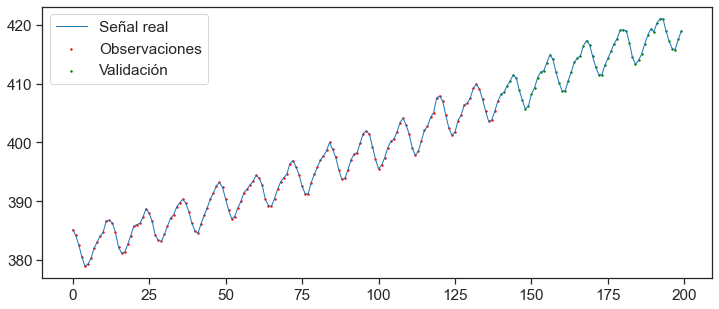

In [173]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.scatter(t_val, y_val, c='g', s = 2, label='Validación')
plt.legend()
#plt.xlim(250, 550)
#plt.ylim(340, 380)
plt.show()

In [174]:
tgp = model(CO2_monthly, train_index)

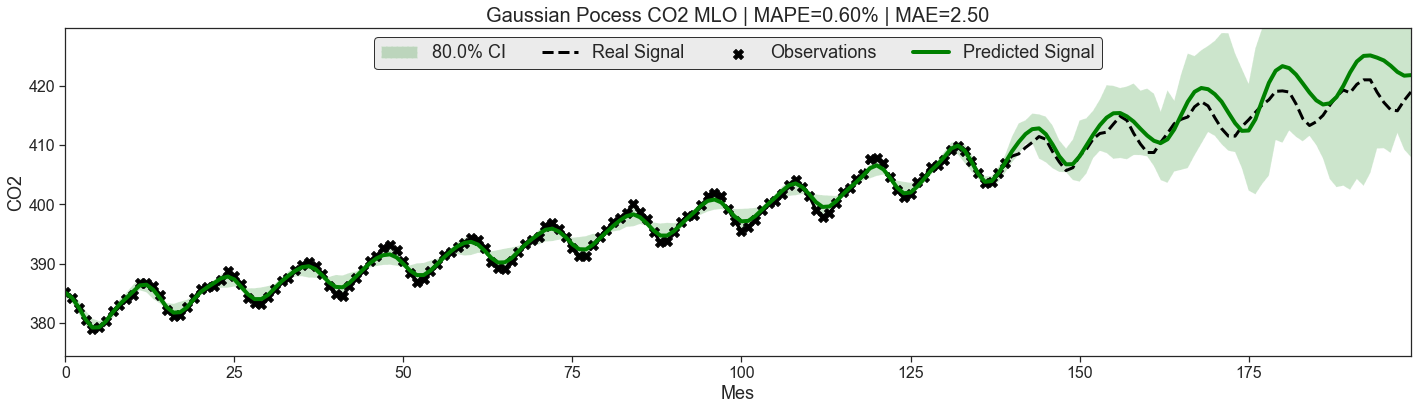

In [175]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

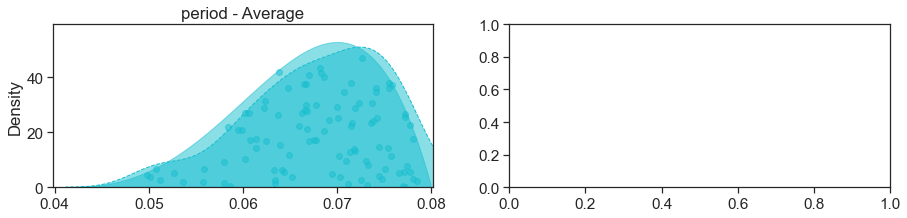

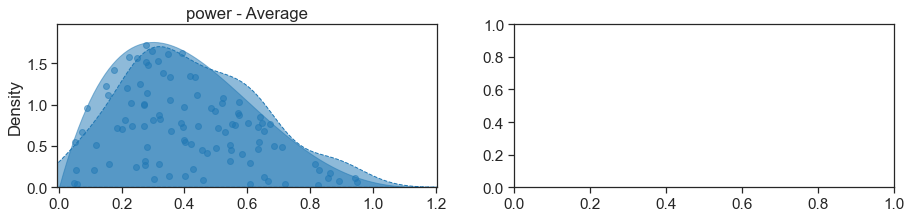

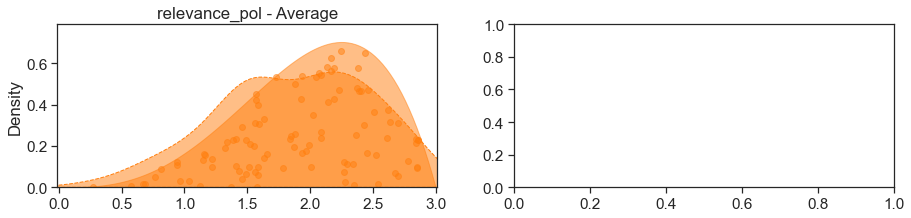

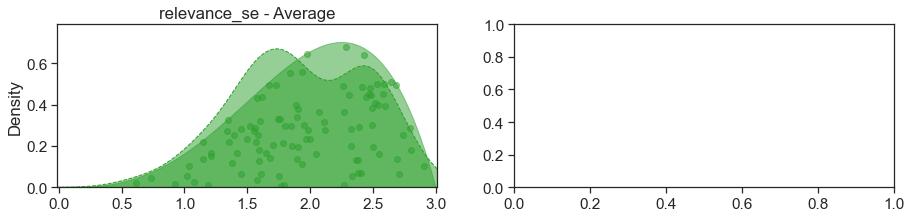

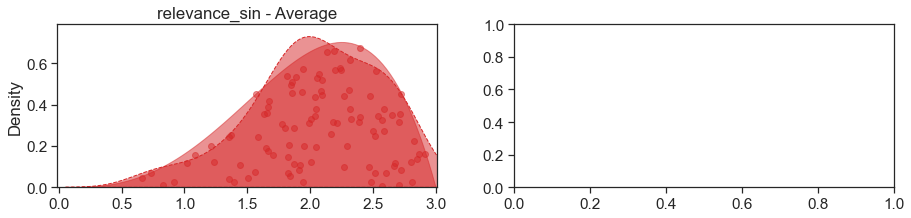

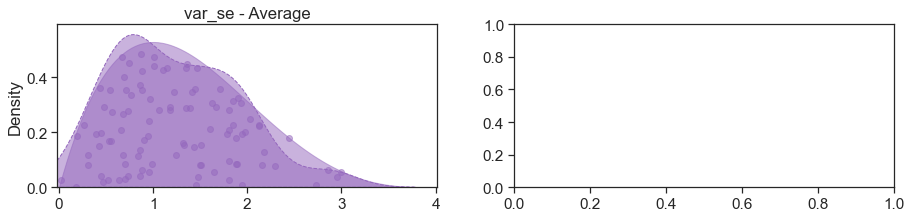

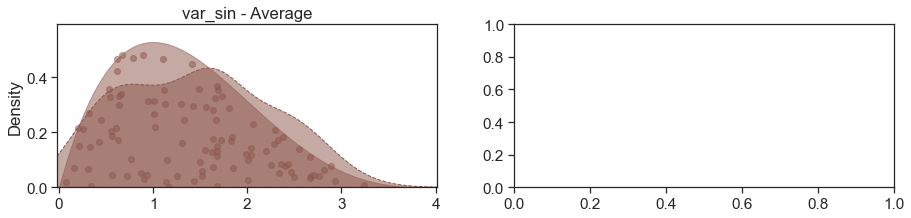

  0%|                                                                                                         …

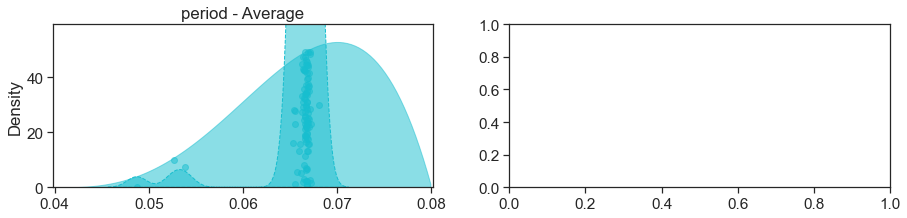

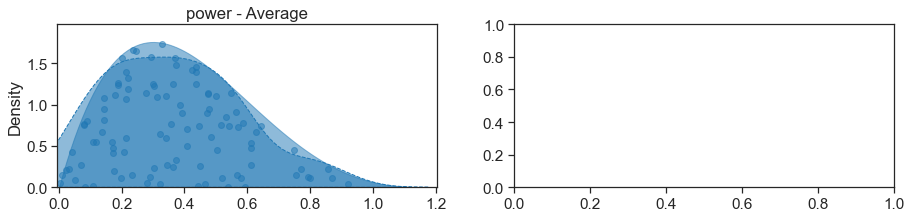

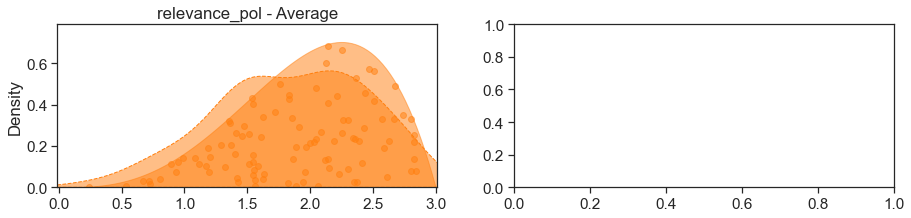

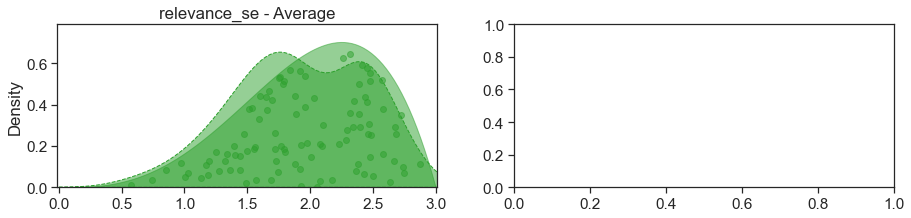

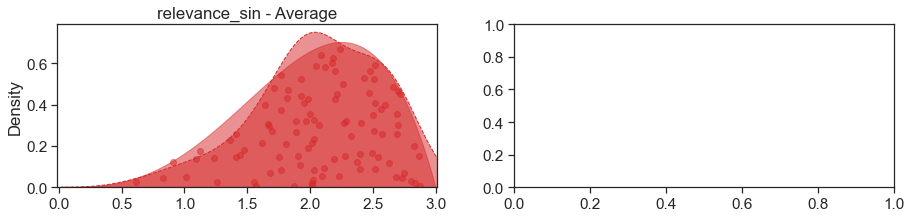

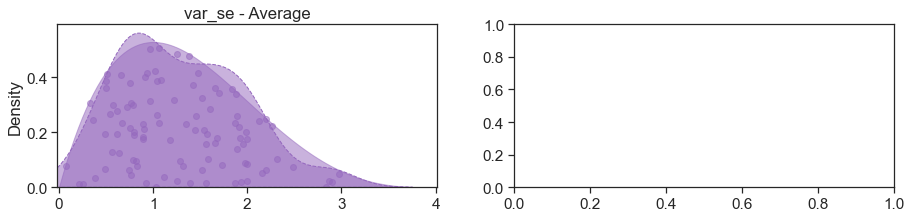

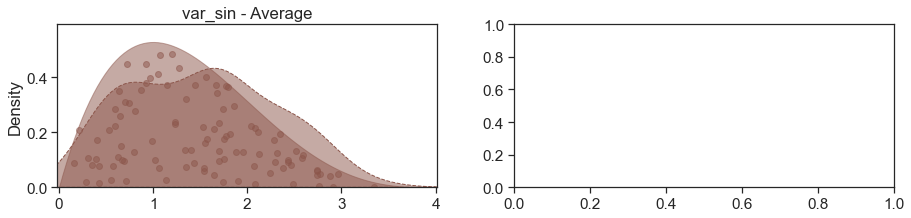

In [176]:
train(tgp)

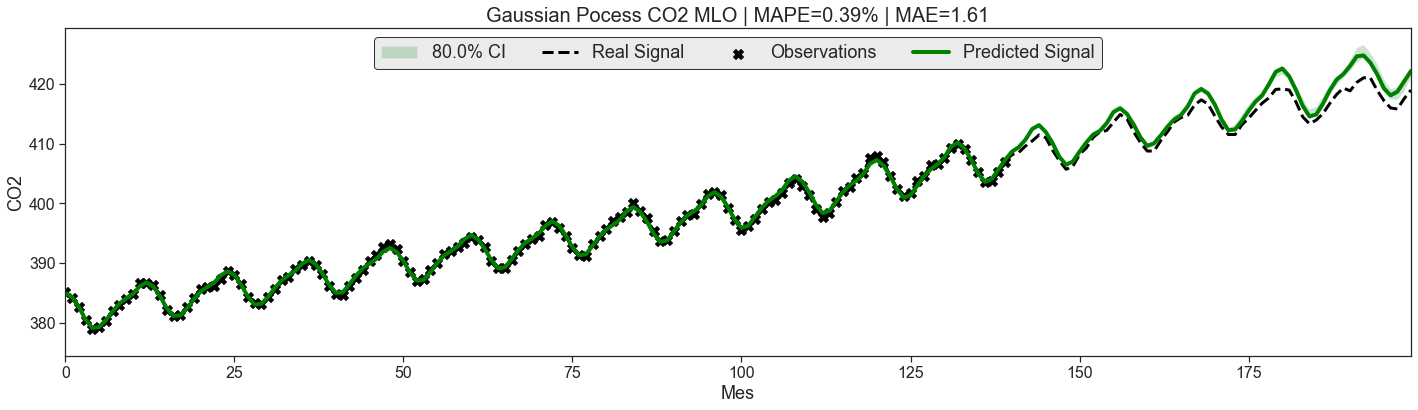

In [177]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

### 70% time with missing data of 80%

In [178]:
t = CO2_monthly['index']
y = CO2_monthly['average']
particion = 0.7
obs_final = int(particion*len(t))
indice_particion = range(obs_final)
t_particion = t[:obs_final]
y_particion = y[:obs_final]
perm = tg.np.random.permutation(indice_particion)
prop = 0.8
nobs = int(prop*len(t))
train_index = np.sort(perm[:nobs])
#aqui la validacion se hace sobre los datos a predecir
valid_index = range(obs_final, len(t))
t_obs = t[train_index]
y_obs = y[train_index]

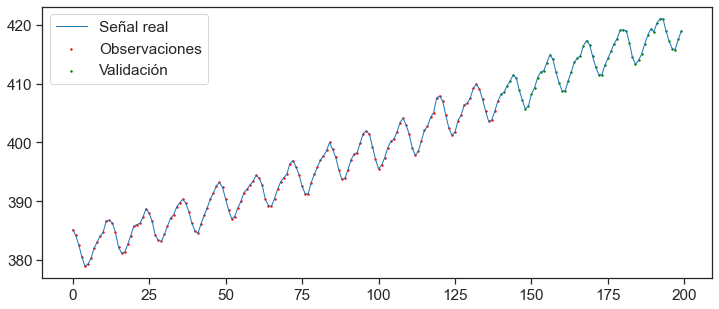

In [179]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.scatter(t_val, y_val, c='g', s = 2, label='Validación')
plt.legend()
#plt.xlim(250, 550)
#plt.ylim(340, 380)
plt.show()

In [180]:
tgp = model(CO2_monthly, train_index)

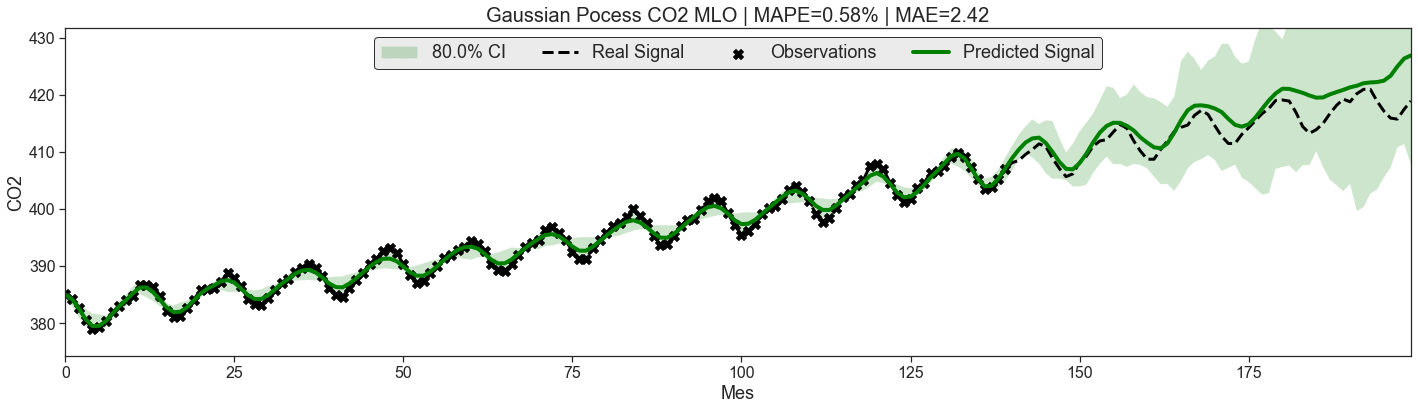

In [181]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=False, 
                 noise=True, samples_kwargs={'alpha':0.1}, ylim_by_CI=False)

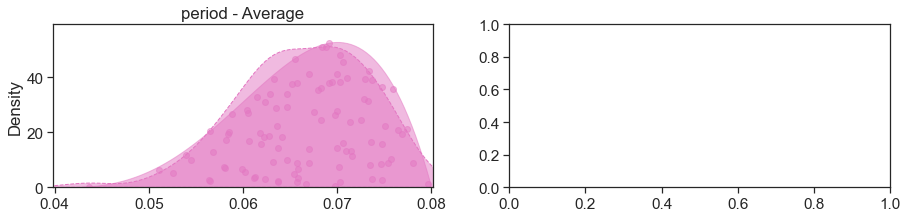

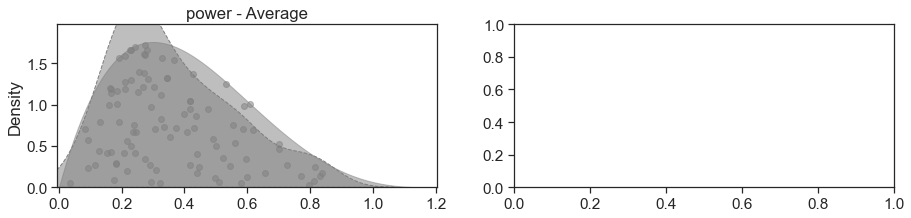

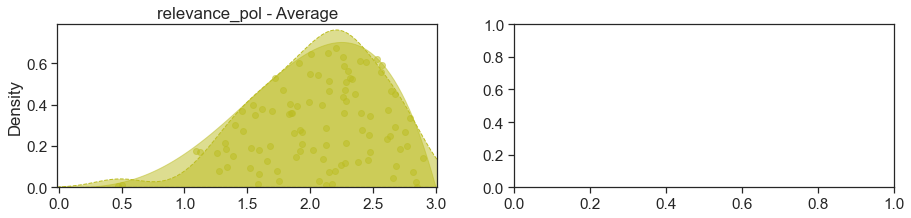

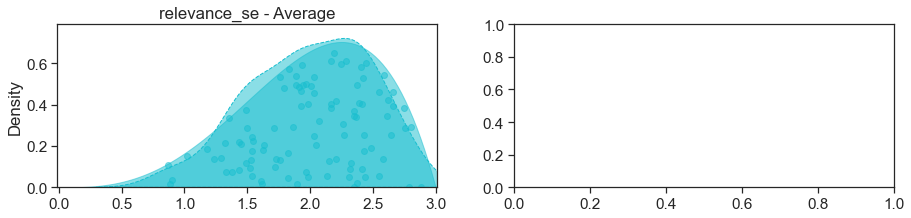

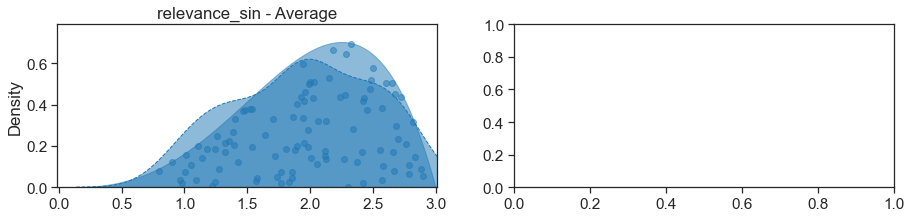

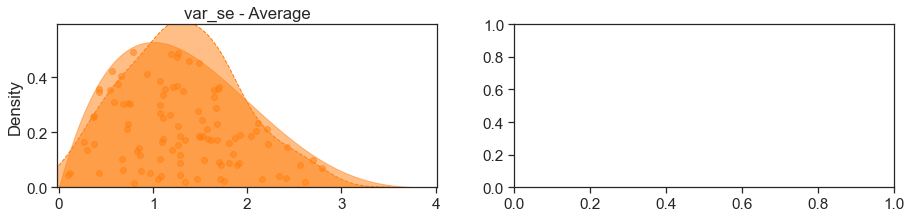

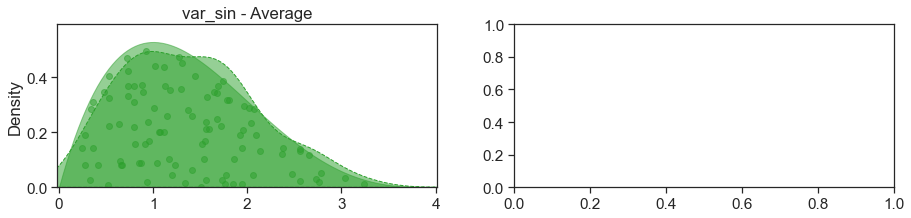

  0%|                                                                                                         …

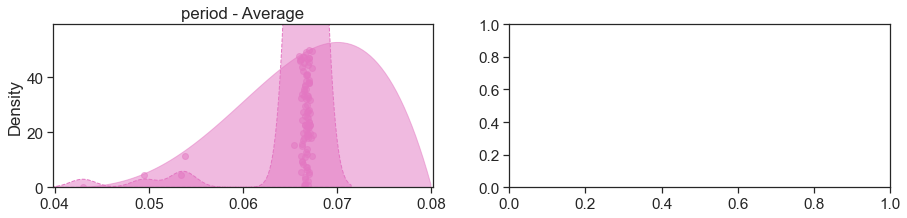

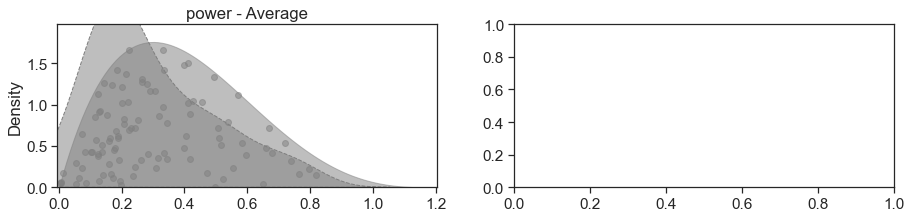

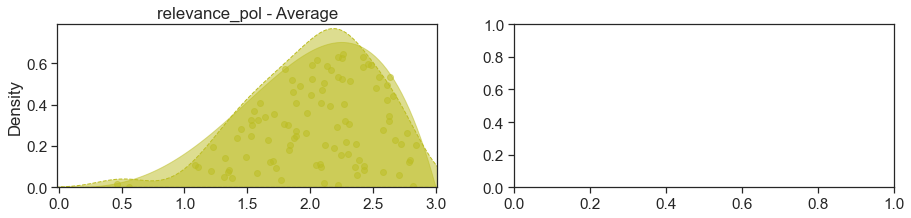

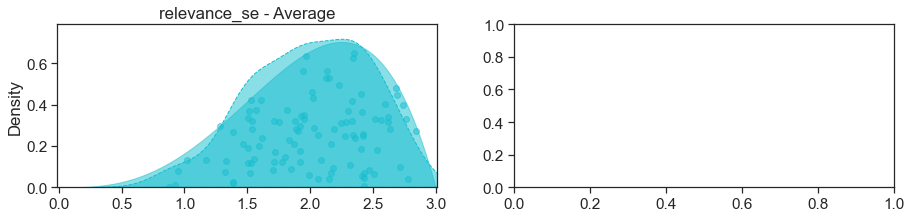

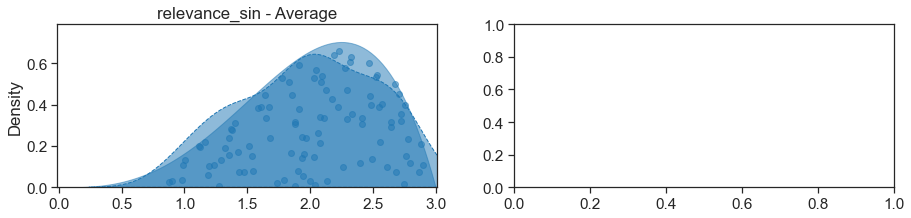

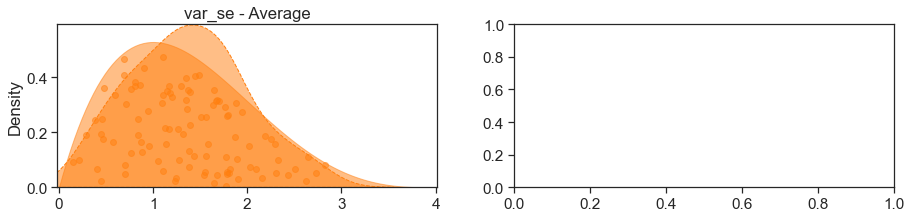

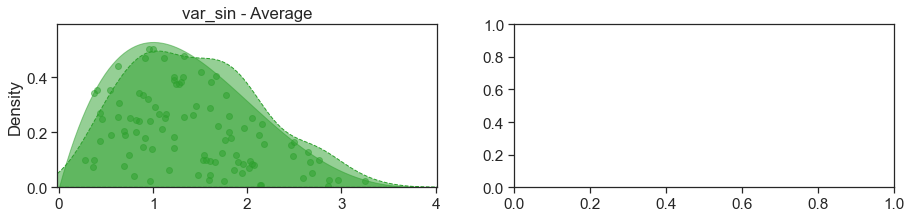

In [182]:
train(tgp)

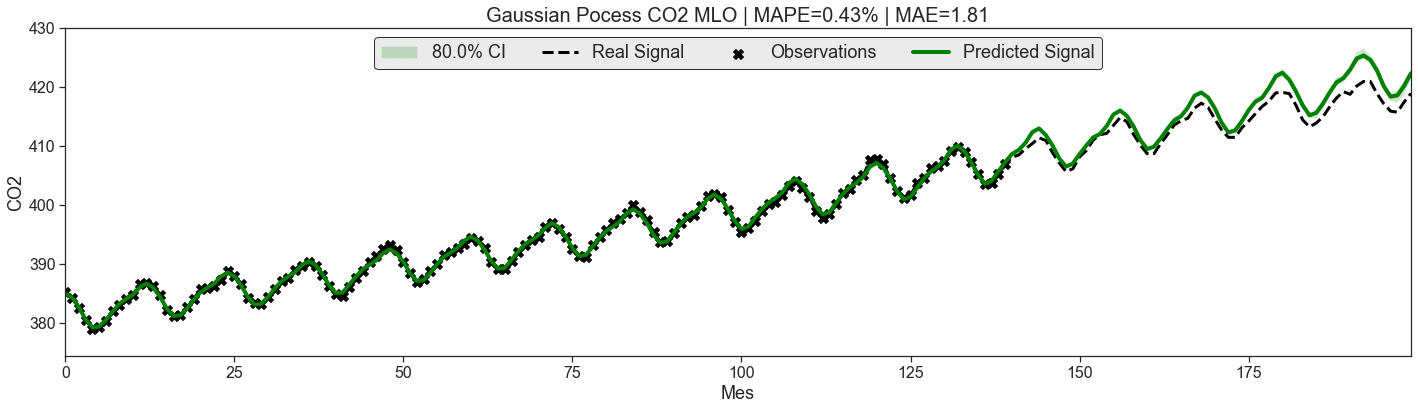

In [197]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index,
                 noise=True, ylim_by_CI=False)

### Resumen

Experimento |MAPE|MAE
-----|-----|----- 
70% time|0.39%|1.61
70% time, missing data|0.43%|1.81

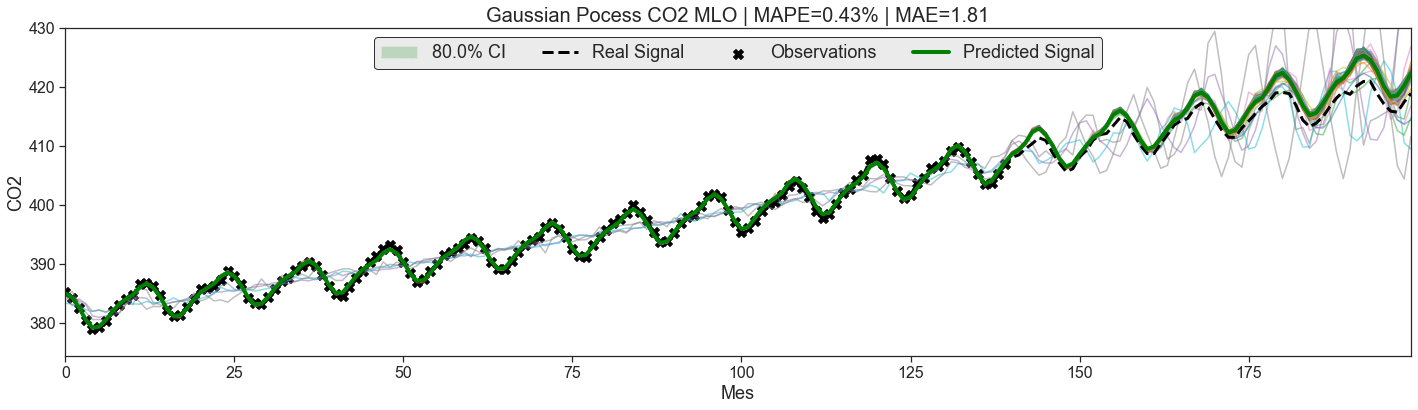

In [196]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=1, valid_index=valid_index, plot_samples=True, 
                 noise=True, ylim_by_CI=False, samples_kwargs={'alpha':0.5})

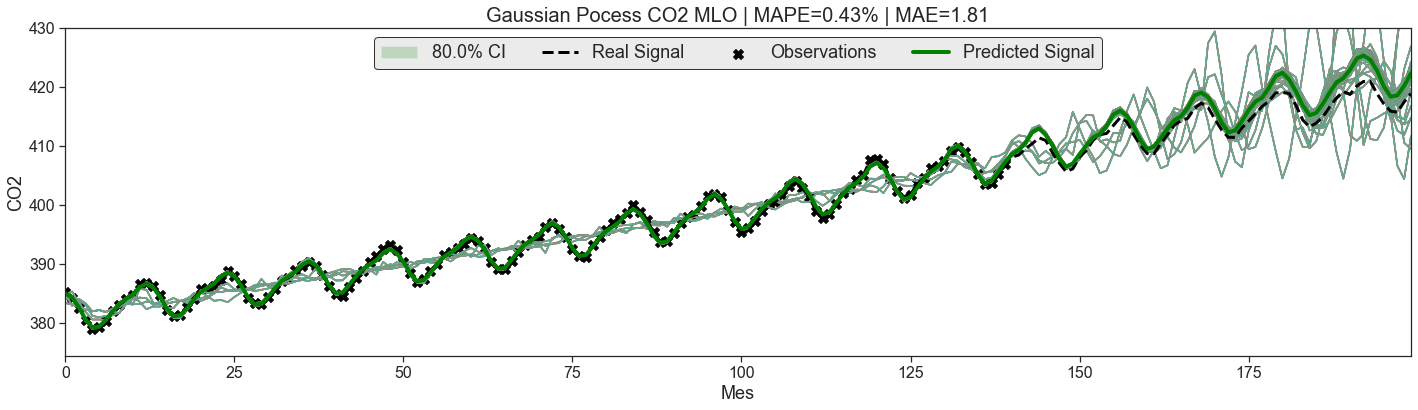

In [198]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=10, valid_index=valid_index, plot_samples=True, 
                 noise=True, ylim_by_CI=False, samples_kwargs={'alpha':0.5})

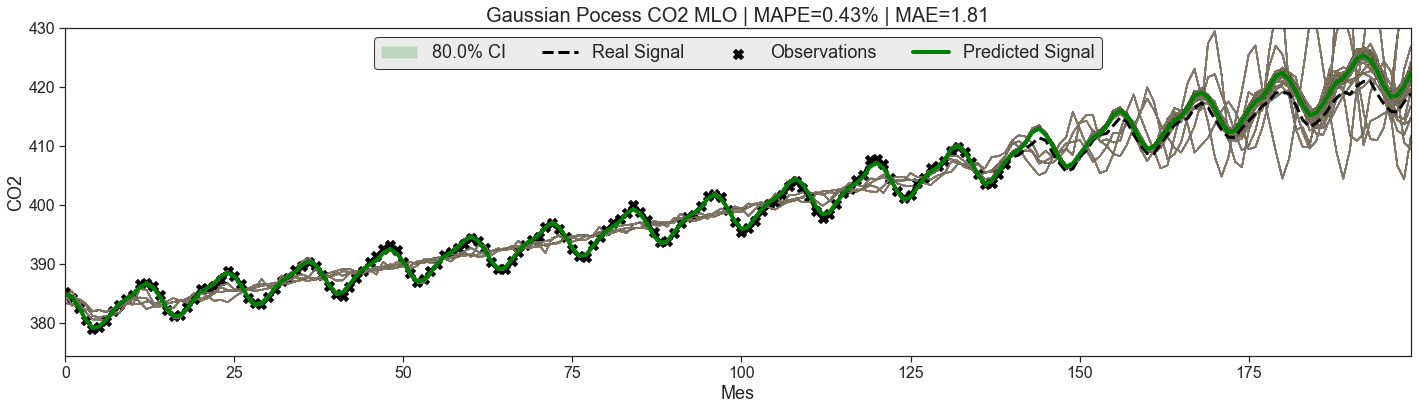

In [190]:
tgp.plot_predict('Gaussian Pocess CO2 MLO', 'Mes', 'CO2', nsamples=100, valid_index=valid_index, plot_samples=True, 
                 noise=True, ylim_by_CI=False)